# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos: Diana Cristina Rojas Romaní**

**Usuario VIU: Drojasr@student.universidadviu.com**

---
# Resumen
---

La predicción es lo que se busca actualmente para tener de antemano información necesaria y proyectarse ante un evento. En esta práctica se busca predecir casos de dengue el cual es transmitido por mosquitos y tiene una dinámica de transmisión basada en varios factores. Se realizó una limpieza y reexploración de la data de entrenamiento y luego de la data de test.También se realizó nuevamente parte de la práctica 1 a fin de implementar Cross validation y de crear y/o eliminar características lo cual aportó en gran medida a la disminución del MAE(Mean Absolute Error). Después se ejecutó predicciones mediante el uso de algoritmos supervisados de regresión dentro de los cuales se evaluó varios rangos de hiperparámetros a fin de optimizar la predicción.
Se logró mejores valores MAE (27.2) con los algoritmos KNN (k vecinos) y Random Forest añadiendo imputaciones de interpolación, optimizadores y manejo de las características.


In [212]:
# Cabe resaltar que he creado varias cuentas de gmail para realizar las pruebas suficientes en la página web DRIVEN DATA, los resultados de los valores MAE de cada algoritmo escogido estarán al final de este cuaderno.

---
# Inicialización
---

In [213]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs


import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import seaborn as sns
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

seed = 38  # Semilla aleatoria arbitraria y constante a incluir en los algoritmos estocásticos para que los experimentos sean siempre reproducibles por el profesor.
# OJO: En los experimentos estocásticos que requieran varias iteraciones con distintas semillas, podéis incorporarla como seed+1, seed+2, etc.

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [214]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train (3).csv
User uploaded file "dengue_features_train (3).csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [215]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_labels_train.csv to dengue_labels_train (3).csv
User uploaded file "dengue_labels_train (3).csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [216]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test (3).csv
User uploaded file "dengue_features_test (3).csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [217]:
test.tail(18)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
398,iq,2013,9,2013-02-26,0.345517,0.346867,0.337117,0.382550,39.19,297.000000,...,62.40,96.022857,39.19,17.891429,7.700000,27.600000,9.566667,34.2,21.8,111.3
399,iq,2013,10,2013-03-05,0.295343,0.309857,0.254686,0.263729,111.09,296.958571,...,69.20,97.478571,111.09,18.120000,6.185714,27.733333,9.533333,34.2,22.6,149.9
400,iq,2013,11,2013-03-12,0.223671,0.119450,0.224800,0.228371,27.21,297.935714,...,97.00,95.540000,27.21,18.754286,8.328571,28.366667,10.533333,34.3,22.2,35.1
401,iq,2013,12,2013-03-19,0.231800,0.195583,0.204786,0.250186,76.86,298.188571,...,111.30,96.748571,76.86,19.377143,7.128571,27.900000,9.166667,34.9,22.8,0.0
402,iq,2013,13,2013-03-26,0.263429,0.210614,0.269414,0.245871,104.47,298.327143,...,81.72,94.218571,104.47,18.892857,8.942857,28.150000,11.150000,34.2,22.0,70.6
403,iq,2013,14,2013-04-02,0.223543,0.208543,0.239971,0.218557,122.60,297.621429,...,131.30,94.630000,122.60,18.148571,8.000000,28.700000,10.833333,34.8,21.8,36.8
404,iq,2013,15,2013-04-09,0.263200,0.237400,0.250143,0.199114,88.07,297.754286,...,52.20,93.091429,88.07,17.910000,9.400000,27.633333,9.533333,33.6,22.0,54.1
405,iq,2013,16,2013-04-16,0.309029,0.270267,0.235500,0.259686,44.30,298.647143,...,121.00,91.862857,44.30,18.632857,8.357143,28.333333,10.000000,34.2,22.4,53.6
406,iq,2013,17,2013-04-23,0.193314,0.247057,0.275643,0.372729,71.07,297.202857,...,58.20,96.580000,71.07,18.180000,7.200000,26.950000,9.350000,33.6,21.2,74.9
407,iq,2013,18,2013-04-30,0.385143,0.369700,0.375933,0.354214,2.28,297.981429,...,2.60,77.757143,2.28,14.852857,14.285714,27.250000,13.125000,35.0,18.2,8.9


---
# Reexploración
---

Limpieza de datos

 Se hará un preprocesamiento de datos tal como se realizó en la práctica 1.

In [218]:
# Información de las características del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [219]:
# Descripción del dataset
train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


In [220]:
# Duplicado del dataframe para realizar la limpieza
df_train = train

Se necesita verificar que los datos tengan las unidades adecuadas y seas las mismas en caso se necesite realizar operaciones entre ellas. Se observa que los valores de temperaturas tienen unidades °Celcius y °Kelvin; se uniformizará todas las columnas a °Celcius.

In [221]:
df_train['reanalysis_dew_point_temp_k']= df_train['reanalysis_dew_point_temp_k']-273.15
df_train['reanalysis_air_temp_k']= df_train['reanalysis_air_temp_k']-273.15
df_train['reanalysis_max_air_temp_k']= df_train['reanalysis_max_air_temp_k']-273.15
df_train['reanalysis_min_air_temp_k']= df_train['reanalysis_min_air_temp_k']-273.15
df_train['reanalysis_avg_temp_k']= df_train['reanalysis_avg_temp_k']-273.15
df_train['reanalysis_tdtr_k']= df_train['reanalysis_tdtr_k']-273.15

TRATAMIENTO DE NULOS

Text(0, 0.5, 'Filas')

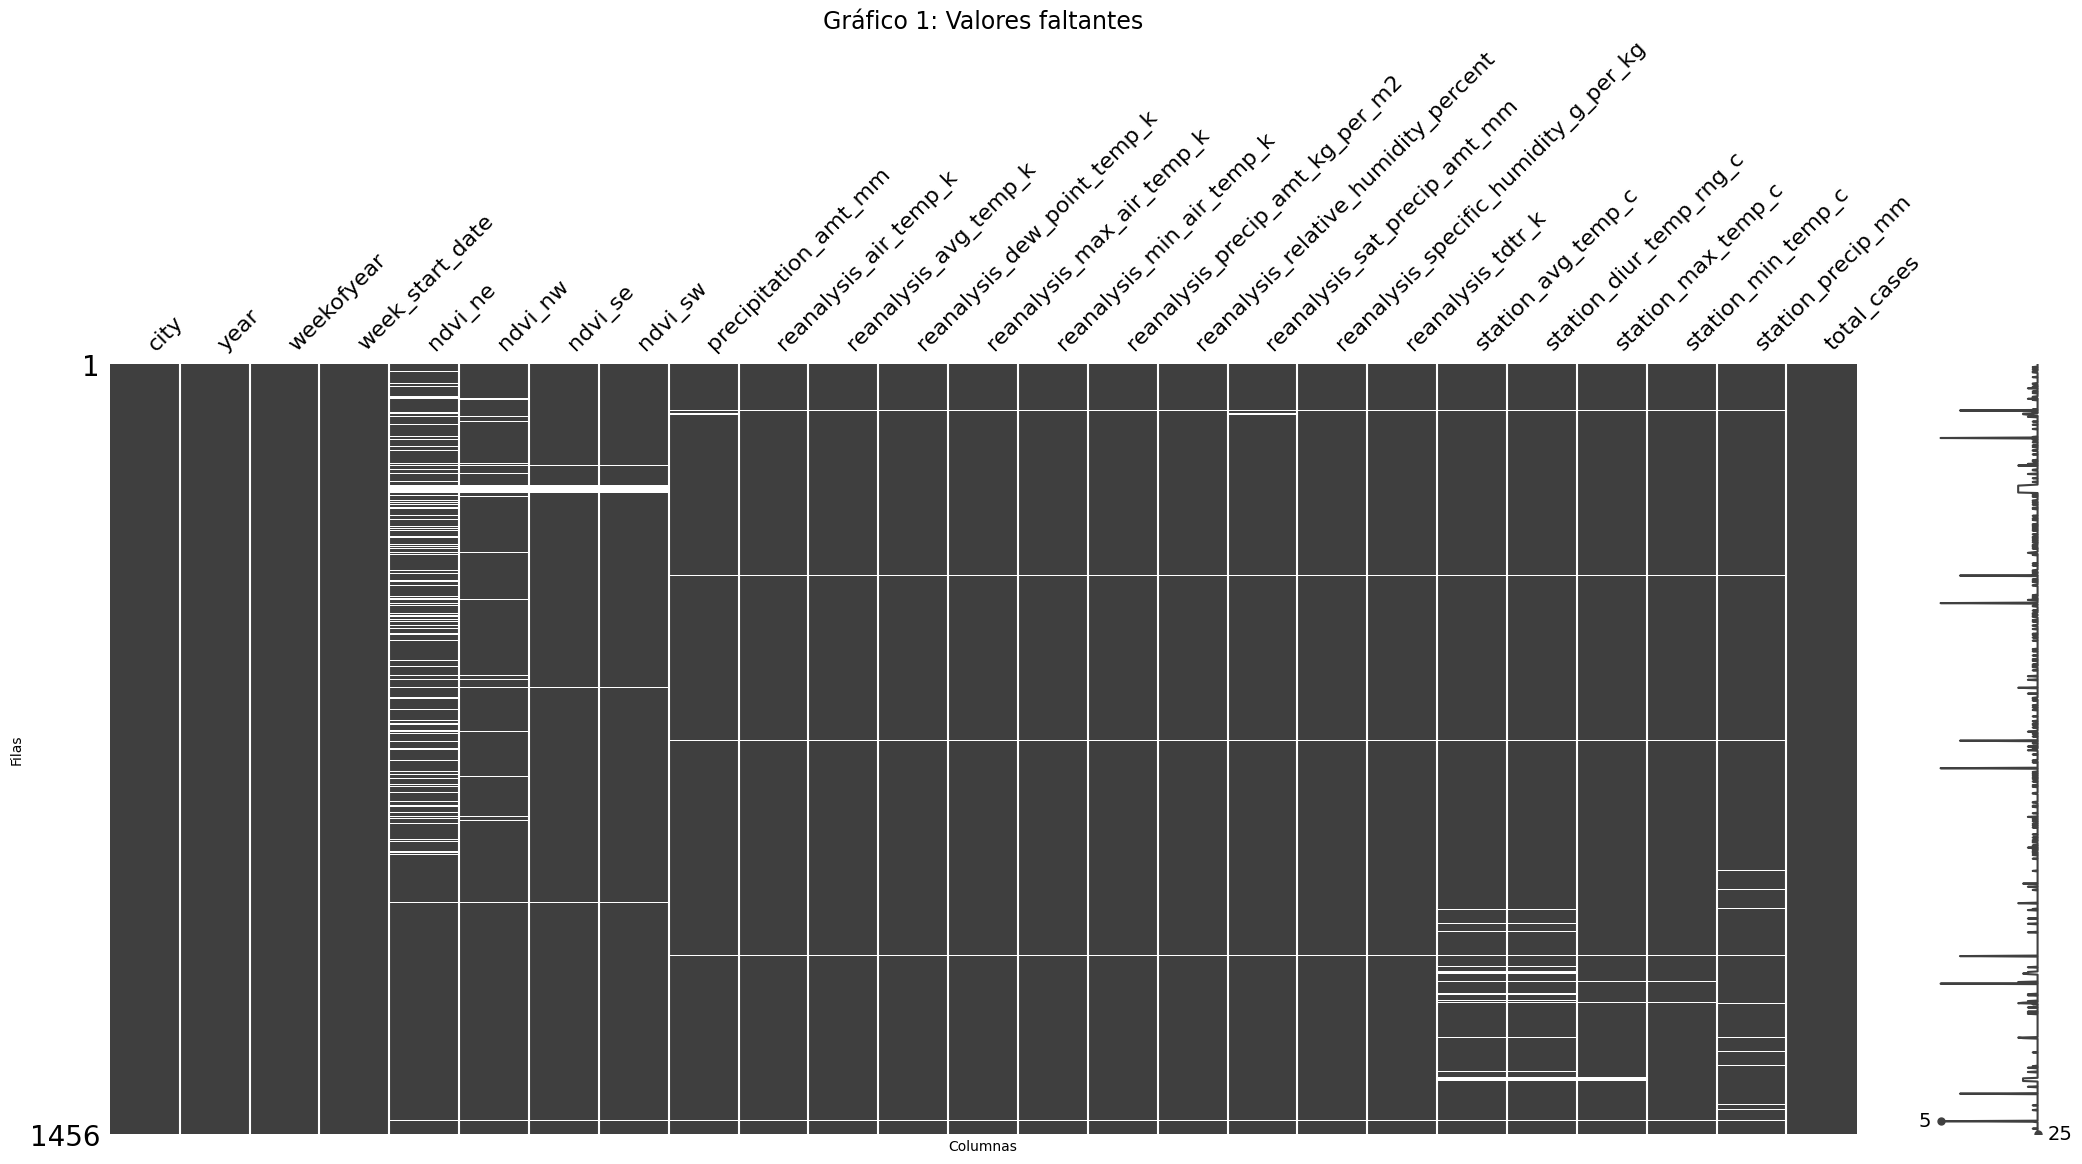

In [222]:
# Determinación de valores faltantes o null para tener una idea de la cantidad de nulos por columnas
msn.matrix(df_train)
plt.title('Gráfico 1: Valores faltantes',  fontsize=17)
plt.xlabel('Columnas')
plt.ylabel('Filas')

Del gráfico se observa que la columna ndvi_ne tiene la mayor cantidad de datos faltantes o null.

In [223]:
# Para determinar la cantidad de esos valores usamos isnull
df_train.isnull().sum()

,0
city,0
year,0
weekofyear,0
week_start_date,0
ndvi_ne,194
ndvi_nw,52
ndvi_se,22
ndvi_sw,22
precipitation_amt_mm,13
reanalysis_air_temp_k,10


En este punto decidimos cómo tratar esos valores faltantes. Para ello analizamos cada columna por separado y para ello podemos ayudarnos de la teoría hallada. Referencias: Tratamiento de valores vacíos I con R y Python: Cómo abordar datos incompletos en tu dataset. https://nicolasurrego.medium.com/tratamiento-de-valores-faltantes-i-c%C3%B3mo-abordar-datos-incompletos-en-tu-dataset-35d51c522842 Identificación e imputación de valores perdidos en Python https://elmundodelosdatos.com/identificacion-valores-perdidos-python/#google_vignette

Ya que las únicas columnas no numéricas sí tienen sus valores completos; mientras que las demás columnas numéricas pueden o no tener valores faltantes. Teniendo en cuenta ello; se procede a realizar la imputación de valores faltantes con la la librería de Scikit learn. https://scikit-learn.org/stable/modules/impute.html

Más referencia: https://www.youtube.com/watch?v=A8ehnDnkrJw

In [224]:
# Definición de las columnas numéricas y city lo convertimos a numérico
# Además, se elimina la columna week_start_date porque esta variable explica muy bien a las columnas year y weekofyear por lo que es redundante.
df_train = df_train.drop(columns=['week_start_date'])
df_train['city'] = df_train['city'].replace({'sj': 1, 'iq': 0})

df_train.head()

<ipython-input-224-7ac496cdb552>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['city'] = df_train['city'].replace({'sj': 1, 'iq': 0})


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,24.422857,24.592857,...,73.365714,12.42,14.012857,-270.521429,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,25.061429,25.292857,...,77.368571,22.82,15.372857,-270.778571,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,25.631429,25.728571,...,82.052857,34.54,16.848571,-270.850000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,25.837143,26.078571,...,80.337143,15.36,16.672857,-270.721429,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,26.368571,26.514286,...,80.460000,7.52,17.210000,-270.135714,28.942857,9.371429,35.0,23.9,5.8,6


Se observa que hay filas que solo tienen 8 columnas con valores del total que son 24 columnas; es decir, no se podría tomar en cuenta dichas filas ya que no tendría sentido analizarlas. Por ejemplo, en la Gráfica 1 se observa la penúltima fila con solo valores de city,year, weekofyear y week_start_date y sus demás valores están ausentes entonces considero que es mejor eliminar dicha fila. A diferencia de otras filas que solo tienen alrededor de 5 o 6 de valores faltantes en las cuales sí valdría la pena realizar una inputación de valores nulos.

In [225]:
# Contar la cantidad de valores nulos por fila
valores_faltantes_fila = df_train.isna().sum(axis=1)

# Identificar filas con al menos 11 valores nulos que es la mitad de las 22 columnas de df_train_num
filas_muchos_faltantes = valores_faltantes_fila >= 11

# Eliminar esas filas
df_train = df_train[~filas_muchos_faltantes]

# Verificar la cantidad de filas eliminadas
print(f"Filas eliminadas: {filas_muchos_faltantes.sum()}")

Filas eliminadas: 10


In [226]:
df_train.shape

(1446, 24)

Ahora, se realizará una imputación de valores faltantes pero solo a la data de entrenamiento en sí el cual es parte de df_train

In [227]:
from sklearn.model_selection import KFold
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd

# Separar variables independientes y dependientes
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

kf = KFold(n_splits=4, shuffle=True, random_state=38)  # Se recomienda `shuffle=True`

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Imputación SOLO en X_train
    imputer = IterativeImputer(max_iter=10, random_state=38)
    imputer.fit(X_train)  # Ajuste solo con el set de entrenamiento

    # Aplicar la transformación en ambos
    X_train_imputed = imputer.transform(X_train)
    X_val_imputed = imputer.transform(X_val)

    # Convertir de nuevo a DataFrame para mantener estructura
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
    X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val.columns, index=X_val.index)

    print("Train Shape:", X_train_imputed.shape)
    print("Validation Shape:", X_val_imputed.shape)



Train Shape: (1084, 23)
Validation Shape: (362, 23)
Train Shape: (1084, 23)
Validation Shape: (362, 23)
Train Shape: (1085, 23)
Validation Shape: (361, 23)
Train Shape: (1085, 23)
Validation Shape: (361, 23)


Ahora, observamos que tanto el dataset df_train fue divido en 10 partes de las cuales cada uno tiene una parte de prueba y otra de test. Se observa que luego de aplicar el Iterative imputer mediante el Cross validation, ambas partes(prueba y test) ya no cuentan con valores nulos.

In [228]:
X_train_imputed.isnull().sum()

,0
city,0
year,0
weekofyear,0
ndvi_ne,0
ndvi_nw,0
ndvi_se,0
ndvi_sw,0
precipitation_amt_mm,0
reanalysis_air_temp_k,0
reanalysis_avg_temp_k,0


In [229]:
X_val_imputed.isnull().sum()

,0
city,0
year,0
weekofyear,0
ndvi_ne,0
ndvi_nw,0
ndvi_se,0
ndvi_sw,0
precipitation_amt_mm,0
reanalysis_air_temp_k,0
reanalysis_avg_temp_k,0


ELIMINACIÓN DE DUPLICADOS

In [230]:
# Concatenar X_train e y_train para eliminar filas duplicadas correctamente
df_train_clean = pd.concat([X_train_imputed, y_train], axis=1)

# Eliminar duplicados
df_train_clean = df_train_clean.drop_duplicates()

# Separar nuevamente en X_train e y_train después de la limpieza
X_train_clean = df_train_clean.drop(columns=['total_cases'])
y_train_clean = df_train_clean['total_cases']

print(X_train_clean.shape, y_train_clean.shape)  # Ambas deben tener el mismo número de filas


(1085, 23) (1085,)


TRATAMIENTO DE OUTLIERS

Analizando X_train para verificar sus outliers

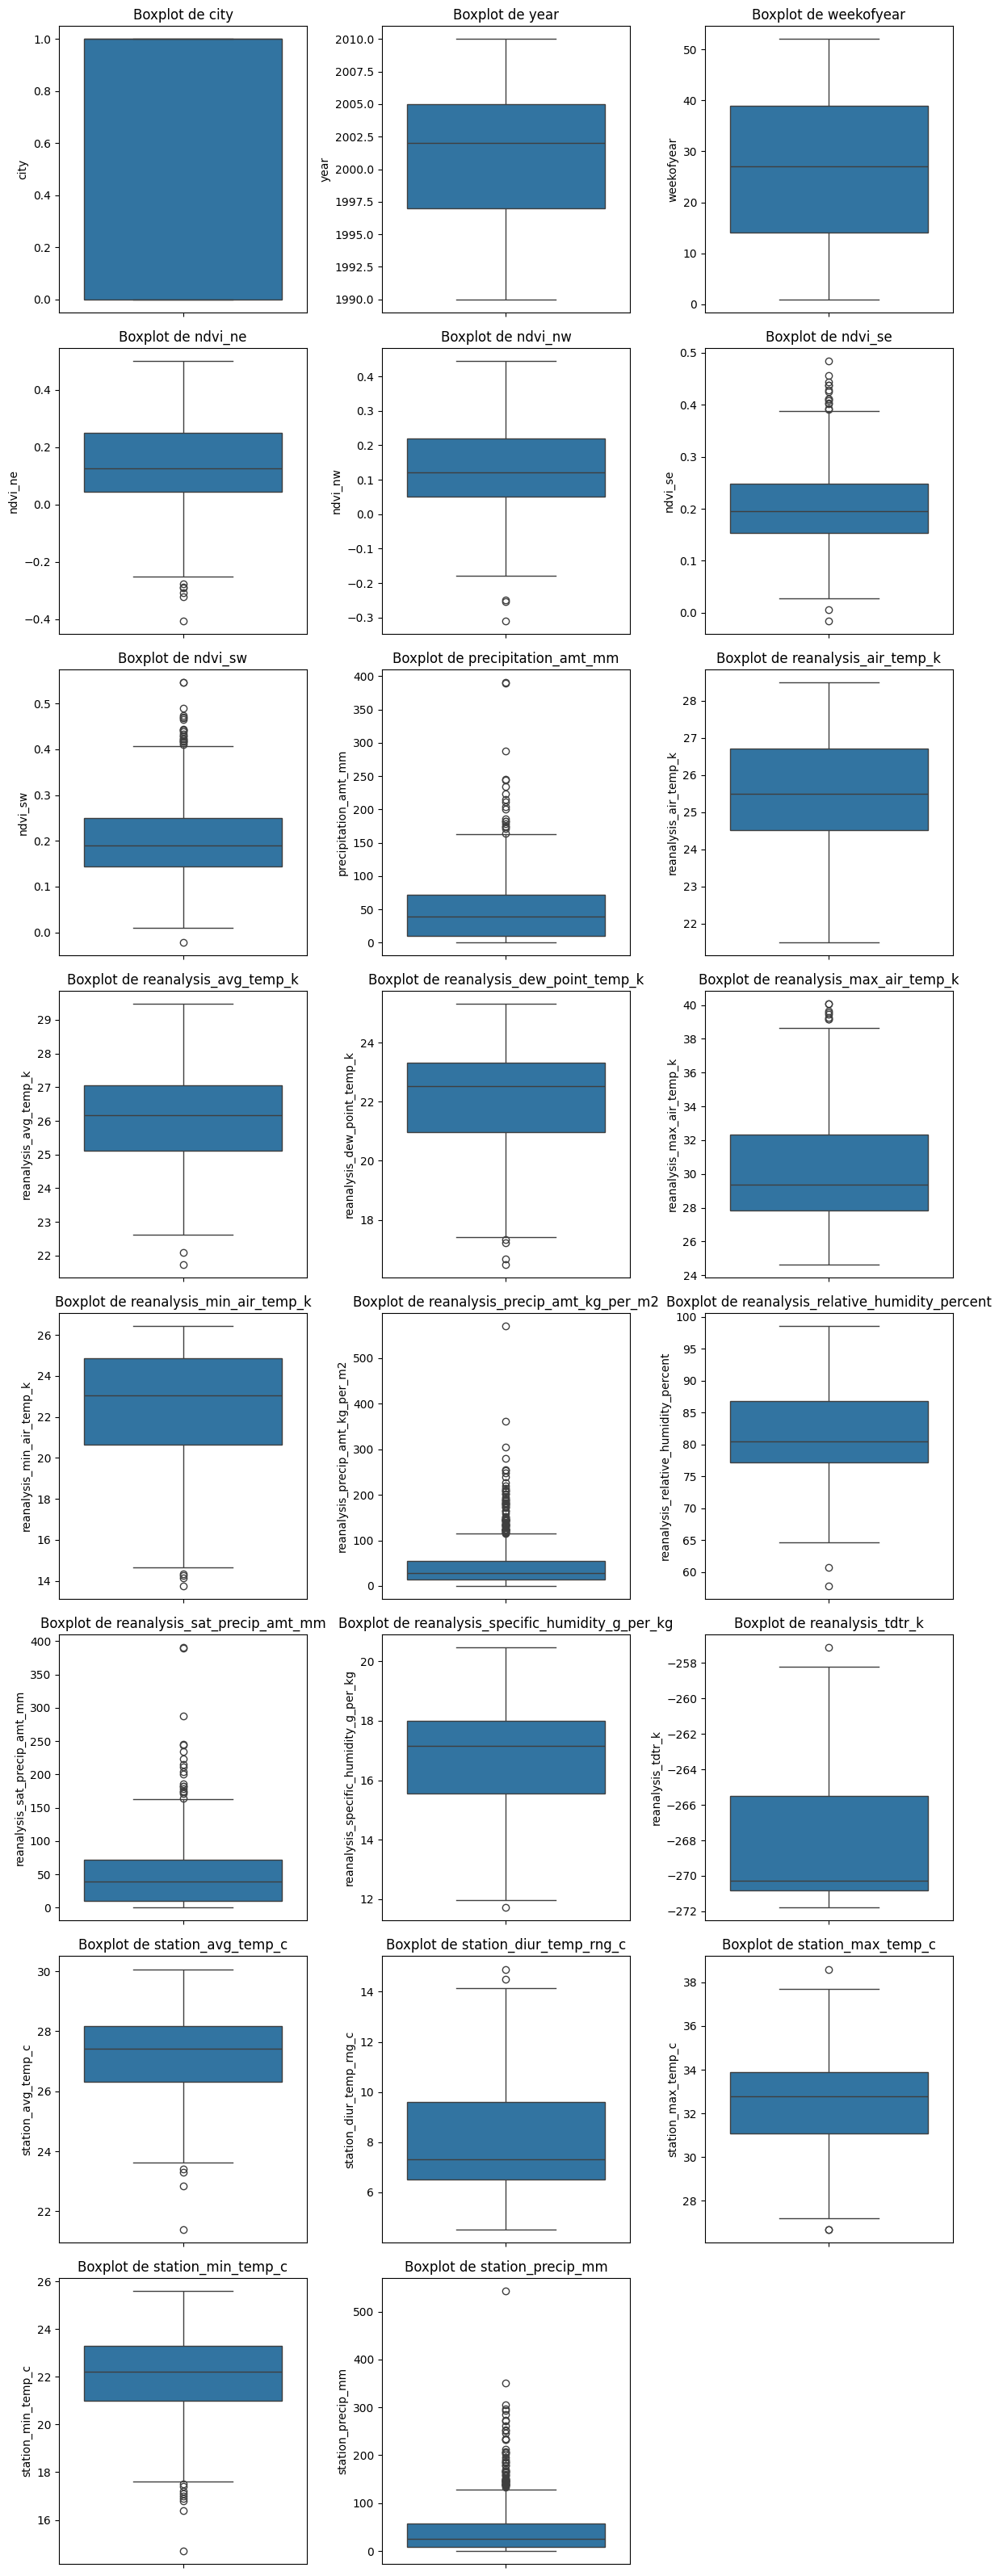

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_boxplots(X_train):
    """
    Genera múltiples gráficos de velas (boxplots) para todas las columnas numéricas de X_train.
    """
    num_columns = X_train.select_dtypes(include=['number']).columns  # Solo columnas numéricas
    num_vars = len(num_columns)
    cols = 3  # Número de columnas en la visualización
    rows = math.ceil(num_vars / cols)  # Determinar filas dinámicamente

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Tamaño ajustable
    axes = axes.flatten()  # Para indexar correctamente

    for i, col in enumerate(num_columns):
        sns.boxplot(y=X_train[col], ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}")

    # Eliminar subgráficos vacíos si hay menos variables que espacios en la cuadrícula
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Llamar a la función con X_train
plot_boxplots(X_train)


De acuerdo a la página EOS DATA ANALYTICS donde se especifica el rango del índice NDVI; no se reemplazará los outliers de NDVI de acuerdo por lo siguiente:

"Este índice está definido por valores que van de -1.0 a 1.0, donde los valores negativos están formados principalmente por nubes, agua y nieve, y los valores negativos cercanos a cero están formados principalmente por rocas y suelo descubierto.

Los valores muy pequeños (0,1 o menos) de la función NDVI corresponden a áreas sin rocas, arena o nieve.

Los valores moderados (de 0,2 a 0,3) representan arbustos y praderas.

Los valores grandes (de 0,6 a 0,8) indican bosques templados y tropicales."

Debido a que en este pequeño rango importan los decimales, se conservará los "outliers" para estas variables NDVI ya que en realidad son valores reales y altamente influyentes en el análisis.

https://eos.com/es/make-an-analysis/ndvi/

Analizando las demás columnas, se tiene lo siguiente:

1° La siguientes columnas tienen valores puntuales por debajo o por encima de los límites por lo que serán reemplazados con los límites superior o inferior según sea el caso.

reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_relative_humidity_percent
station_max_temp_c
2° En el caso de las variables reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm y station_precip_mm no modificaremos ya que en la gráfica se observa que dichos valores se alejan demasiado de la muchos valores que a su vez también están fuera del límite inferior o superior. En estos casos no se debe reemplazar los valores fuera del límite superior ya que hay muchos valores que están en este rango y su análisis posterior es necesario.

Analizando la variable objetivo

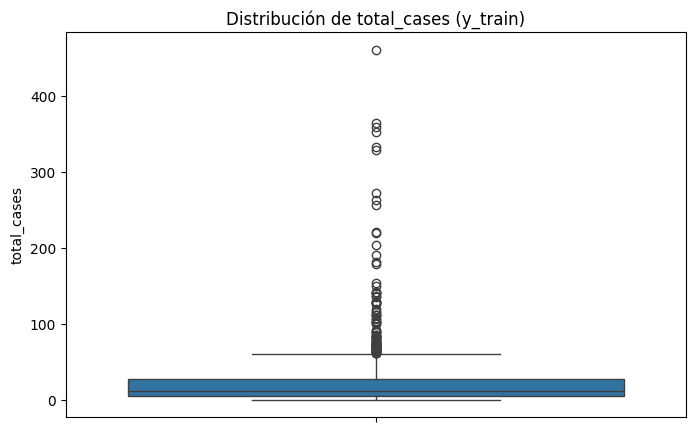

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar un boxplot para analizar outliers en y_train
plt.figure(figsize=(8, 5))
sns.boxplot(y=y_train)
plt.title("Distribución de total_cases (y_train)")
plt.show()


Realizamos una gráfica de barras para observar la distribución de los outliers de y_train

En el caso de y_train y y_val no se aplicará reemplazo de outliers porque se trata del diagnóstico del número de casos de Dengue lo cual sería fatal dar falsos negativos y no tendría mayores consecuencias dar falsos positivos.

Definimos la función para eliminar outliers

In [233]:
import numpy as np
import pandas as pd

def replace_outliers_with_mean(X, columns=None):
    """
    Reemplaza los outliers en un DataFrame usando el método de rango intercuartílico (IQR).
    En lugar de eliminarlos, los reemplaza con el promedio de los valores dentro de los límites.

    Parámetros:
    - X: DataFrame a procesar.
    - columns: Lista de columnas donde aplicar el reemplazo. Si es None, aplica a todas.

    Retorna:
    - DataFrame con outliers reemplazados solo en las columnas indicadas.
    """
    X_clean = X.copy()  # Copia del dataset para evitar modificaciones directas

    # Si no se especifican columnas, se aplicará a todas
    if columns is None:
        columns = X_clean.columns

    for col in columns:
        if col not in X_clean.columns:  # Si la columna no existe, la ignoramos
            continue

        Q1 = X_clean[col].quantile(0.25)
        Q3 = X_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calcular el promedio de los valores dentro del rango permitido
        inlier_mask = (X_clean[col] >= lower_bound) & (X_clean[col] <= upper_bound)
        mean_value = X_clean[col][inlier_mask].mean()  # Promedio de valores normales

        # Reemplazar outliers con el promedio
        X_clean.loc[X_clean[col] < lower_bound, col] = mean_value
        X_clean.loc[X_clean[col] > upper_bound, col] = mean_value

    return X_clean


Aplicamos cross validation para tratar los outliers

In [234]:
kf = KFold(n_splits=4, shuffle=True, random_state=38)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]

    # Solo aplicar reemplazo en algunas columnas de X_train y X_val
    columnas_a_tratar = ["reanalysis_avg_temp_k", "reanalysis_dew_point_temp_k",
                         "reanalysis_max_air_temp_k", "reanalysis_min_air_temp_k",
                         "reanalysis_relative_humidity_percent", "station_max_temp_c"]

    X_train_clean = replace_outliers_with_mean(X_train, columns=columnas_a_tratar)
    X_val_clean = replace_outliers_with_mean(X_val, columns=columnas_a_tratar)

    print(f"Fold terminado: X_train {X_train_clean.shape}, X_val {X_val_clean.shape}")


Fold terminado: X_train (1084, 23), X_val (362, 23)
Fold terminado: X_train (1084, 23), X_val (362, 23)
Fold terminado: X_train (1085, 23), X_val (361, 23)
Fold terminado: X_train (1085, 23), X_val (361, 23)


ANÁLISIS UNIVARIANTE: HISTOGRAMAS PERCENTILES

Text(0.5, 1.0, 'Gráfico 3: Distribución de precipitation_amt_mm')

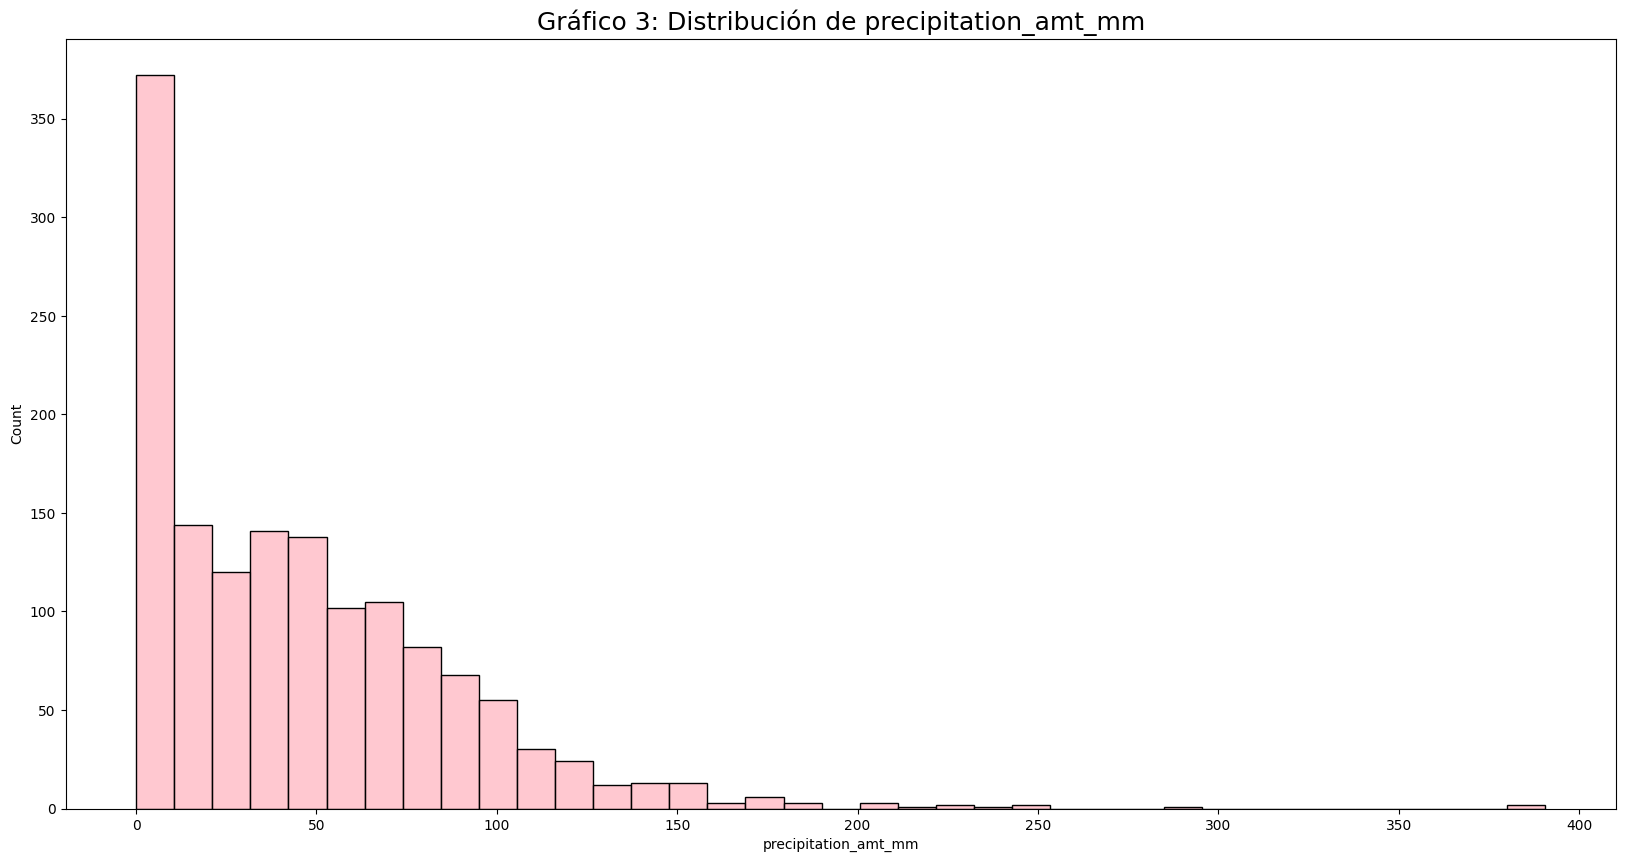

In [235]:
# Análisis univariante de la columna precipitation_amt_mm
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.histplot(data= df_train, x='precipitation_amt_mm', color='#FFB6C1')
plt.title('Gráfico 3: Distribución de precipitation_amt_mm', fontsize=18)



En el gráfico 3 se observa que entre 0 y 100 están los valores de precipitación en el dataset. Incluso se puede decir hasta 150 de valor ya que luego de ese punto se observan escasos casos con mayores precipitaciones a esta.

Text(0.5, 1.0, 'Gráfico 4: Distribución de station_precip_mm')

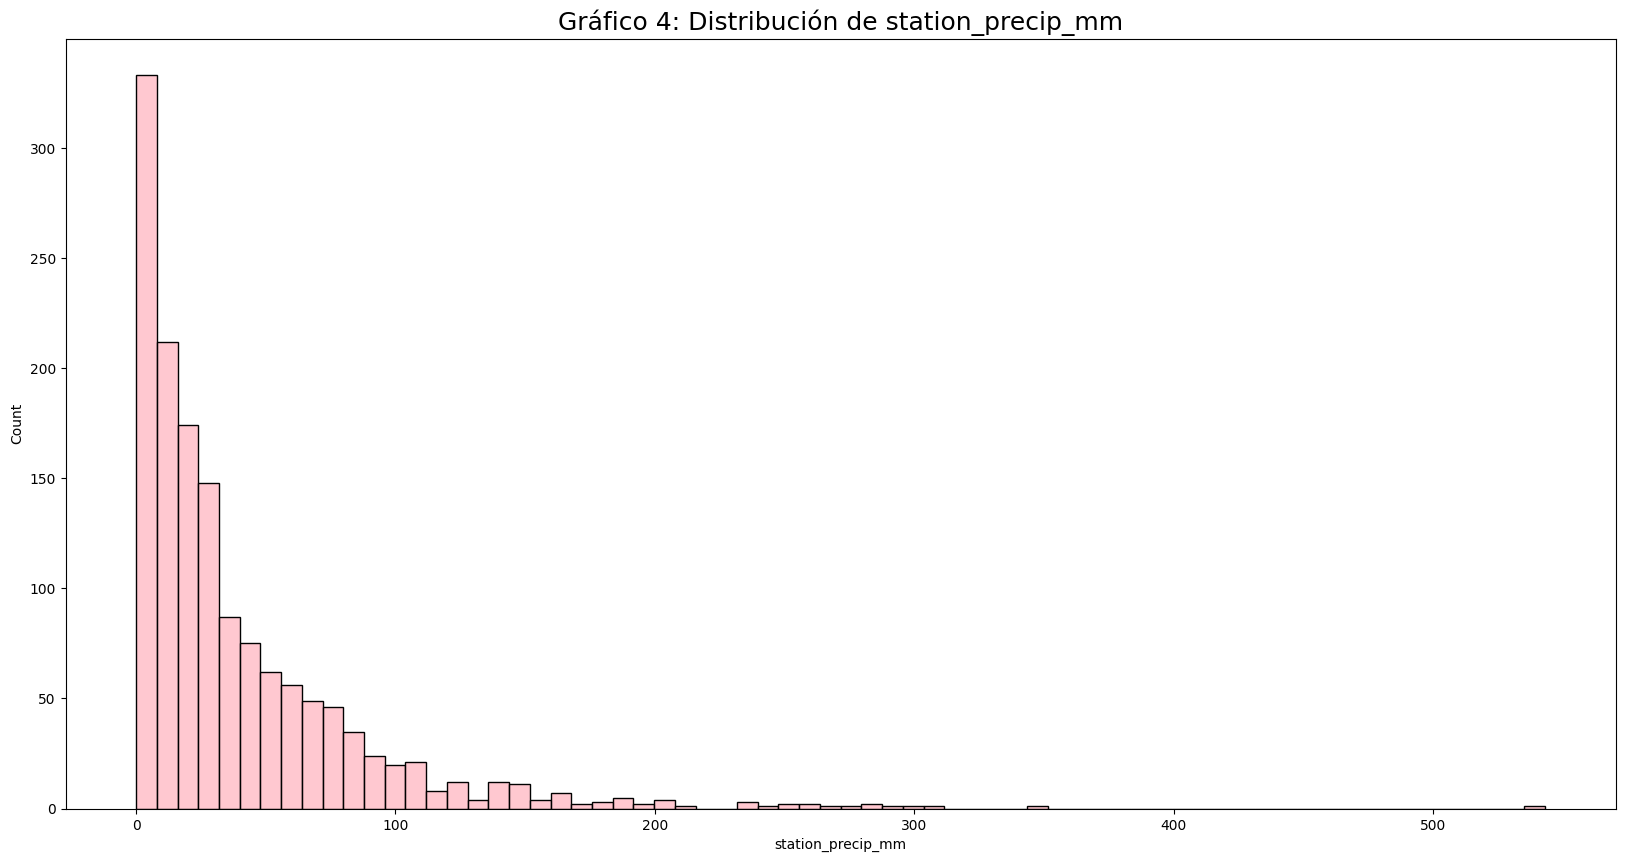

In [236]:
# Análisis univariante de la columna station_precip_mm
plt.figure(figsize=(20, 10))
sns.histplot(data=df_train, x='station_precip_mm', color='#FFB6C1')
plt.title('Gráfico 4: Distribución de station_precip_mm', fontsize=18)


En el gráfico 4 se observa un gráfico similar al del gráfico 3. Esto podría indicarnos que es probable que estas dos variables indiquen lo mismo y podríamos realizar una unificación de caraterísticas.

Observación: las gráficas de la precipitación total tanto las medidas meteorológicamente como medidas por precipitación por satélite son muy parecidas; pasando 10 unidades luego de 100 inician una tendencia casi lineal. Ya que este indicador fue medido mediante dos formas pero al final indican a la misma variables; se puede realizar una unificación de ambas variables más adelante siempre y cuando se observe que tán fuerte es su relación en el mapa de calor

Text(0.5, 1.0, 'Gráfico 5: Distribución de reanalysis_precip_amt_kg_per_m2')

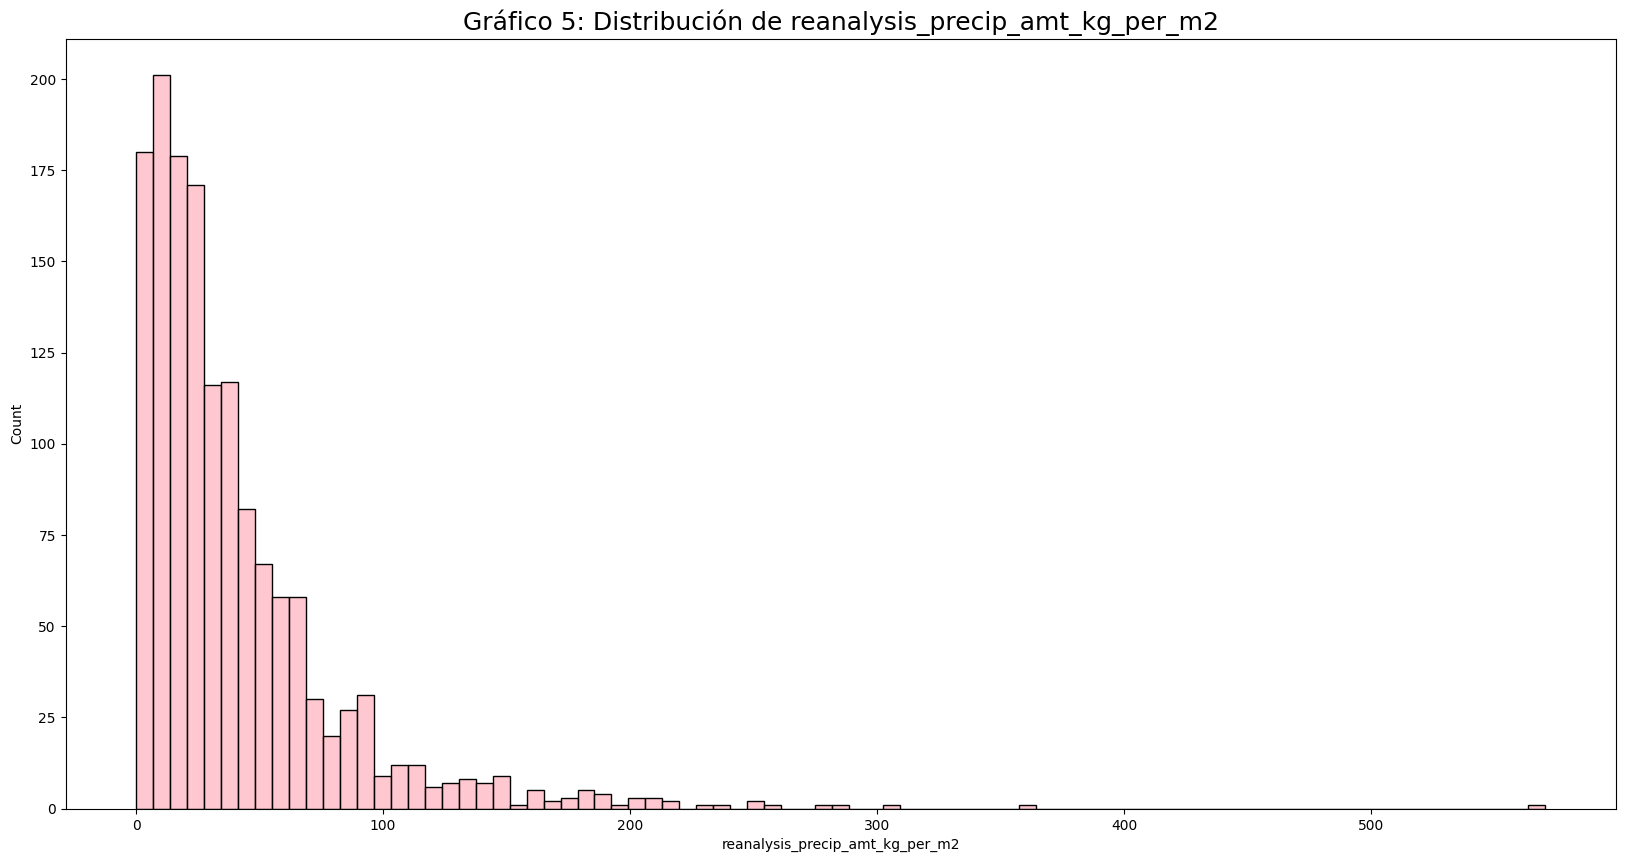

In [237]:
# Análisis univariante de la columna reanalysis_precip_amt_kg_per_m2
plt.figure(figsize=(20, 10))
sns.histplot(data=df_train, x='reanalysis_precip_amt_kg_per_m2', color='#FFB6C1')
plt.title('Gráfico 5: Distribución de reanalysis_precip_amt_kg_per_m2', fontsize=18)

En el gráfico 5 que muestra un reanálisis de la precipitación, se observa una distribución distinta a las precipitaciones mostradas anteriores a este. La mayor cantidad de valores tiene el valor pasando el 0 y aproximadamente a partir del valor 70 van disminuyendo los casos con estos valores de precipitación.

Text(0.5, 1.0, 'Gráfico 6: Distribución de reanalysis_sat_precip_amt_mm')

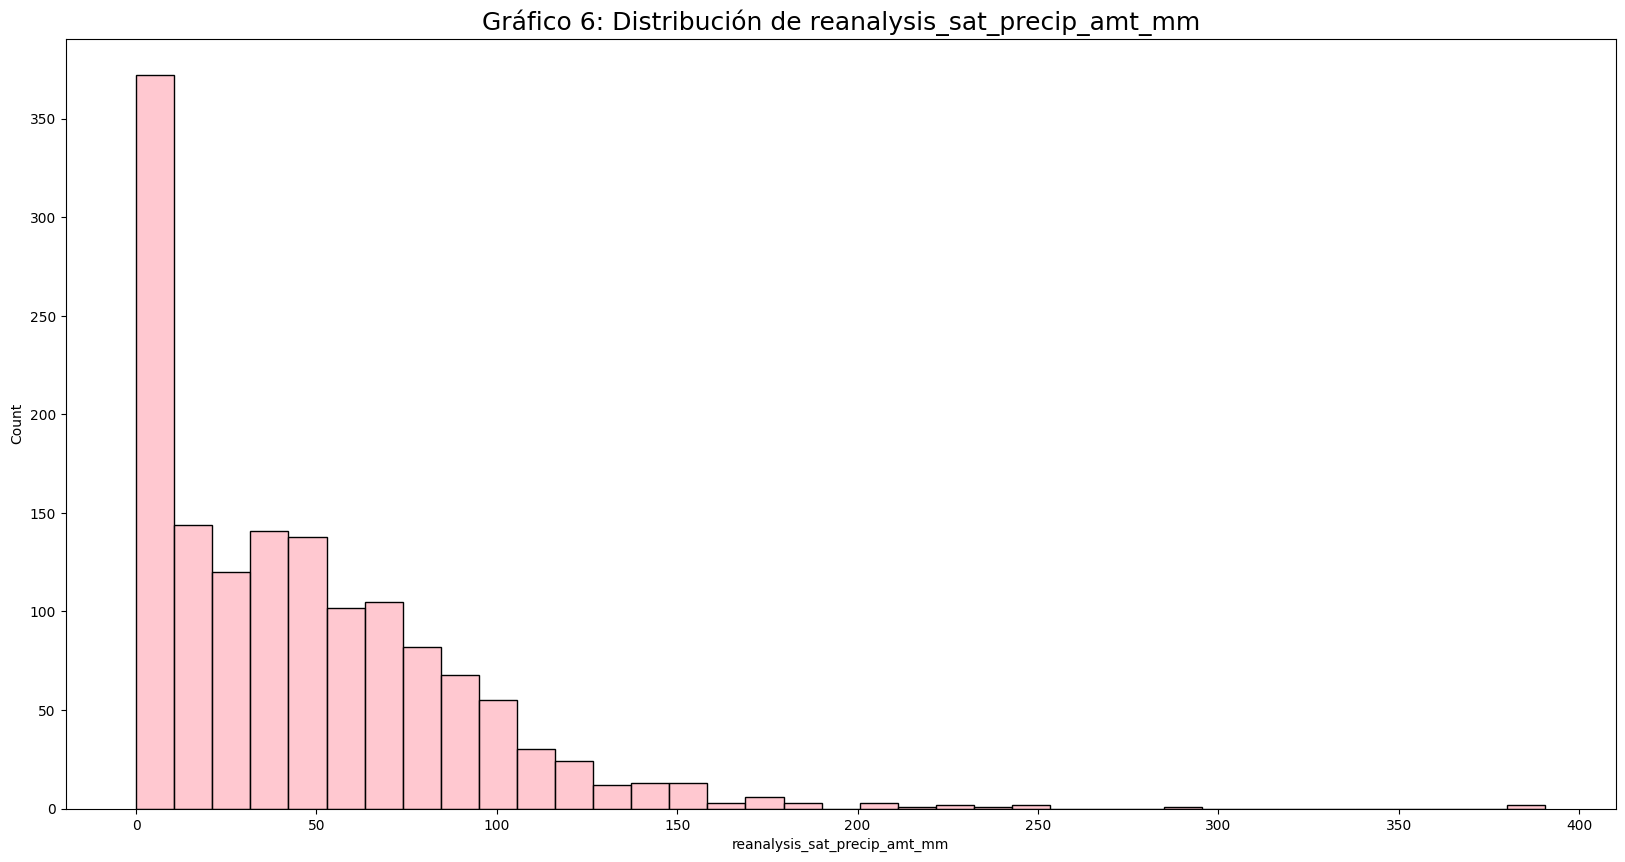

In [238]:
# Análisis univariante de la columna reanalysis_sat_precip_amt_mm
plt.figure(figsize=(20, 10))
sns.histplot(data=df_train, x='reanalysis_sat_precip_amt_mm', color='#FFB6C1')
plt.title('Gráfico 6: Distribución de reanalysis_sat_precip_amt_mm', fontsize=18)

En el gráfico 6 se observa más de 350 de los puntos con una precipitación cercana a 0. La mayoría de los datos tienen precipitación entre 5 y 75; y un menor grupo superan incluso la precipitación de valor 100.

A pesar que los dos reanálisis de precipitación tienen distintas particularidades, ambos son parecidos en la distribución de los valores aislados de precipitación o también podrían catalogarse como outliers.

ANÁLISIS BIVARIANTE: DIAGRAMAS DE DISPERSIÓN 2 A 2

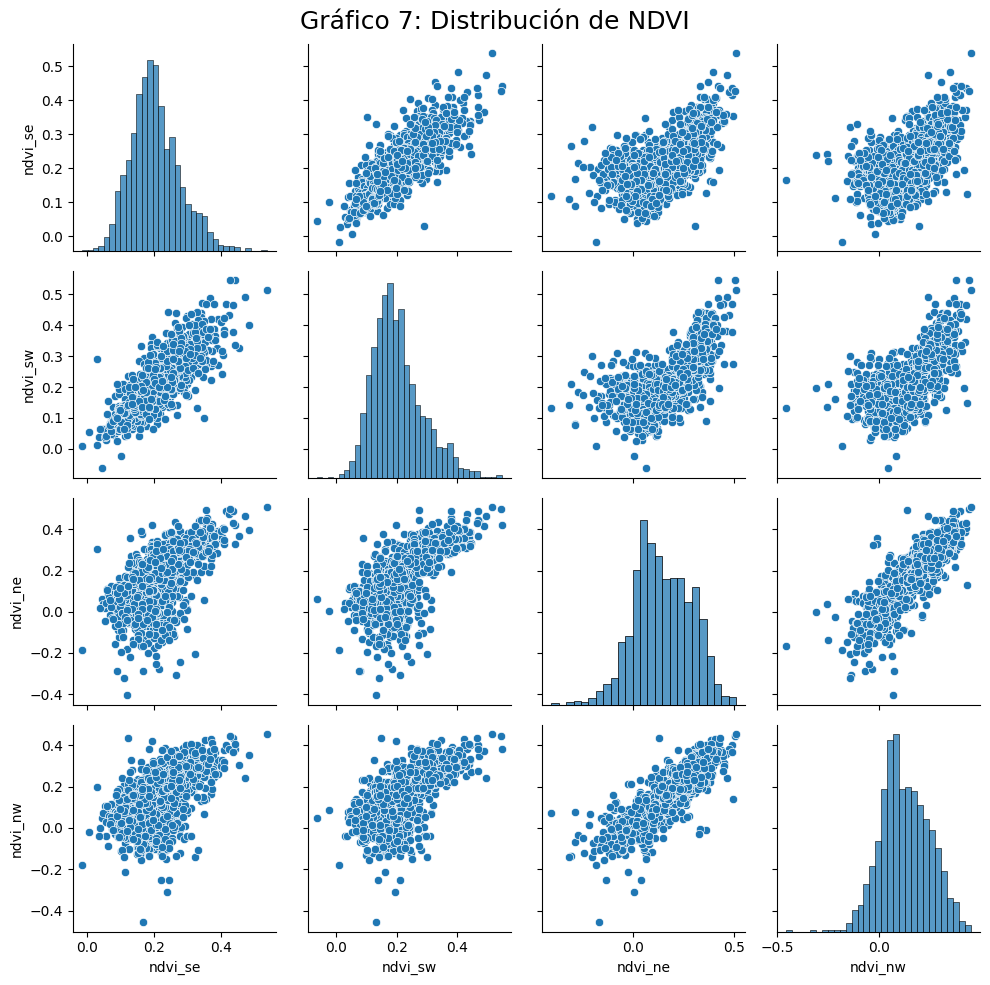

In [239]:
sns.pairplot(df_train[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']])
plt.suptitle('Gráfico 7: Distribución de NDVI', fontsize=18)
plt.tight_layout()
plt.show()

En el gráfico 7 se observa que las distribuciones individuales(en la diagonal) tienen ligeras diferencias entre ellas.
Por ejemplo, hay una correlación positiva entre la cobertura vegetal del sureste (SE) y suroeste(SW); esto podría indicar que en la parte sur hay una continuidad vegetal igual. Del mismo modo se observa la relación entre noreste(NE) y noroeste(NW).
A diferencia de la relación mencionada, en extremos opuestos como noroeste (NW) y sureste(SE) se tiene una relación débil lo cual indica que ambas zonas tienen vegetación o no independientemente una de la otra.

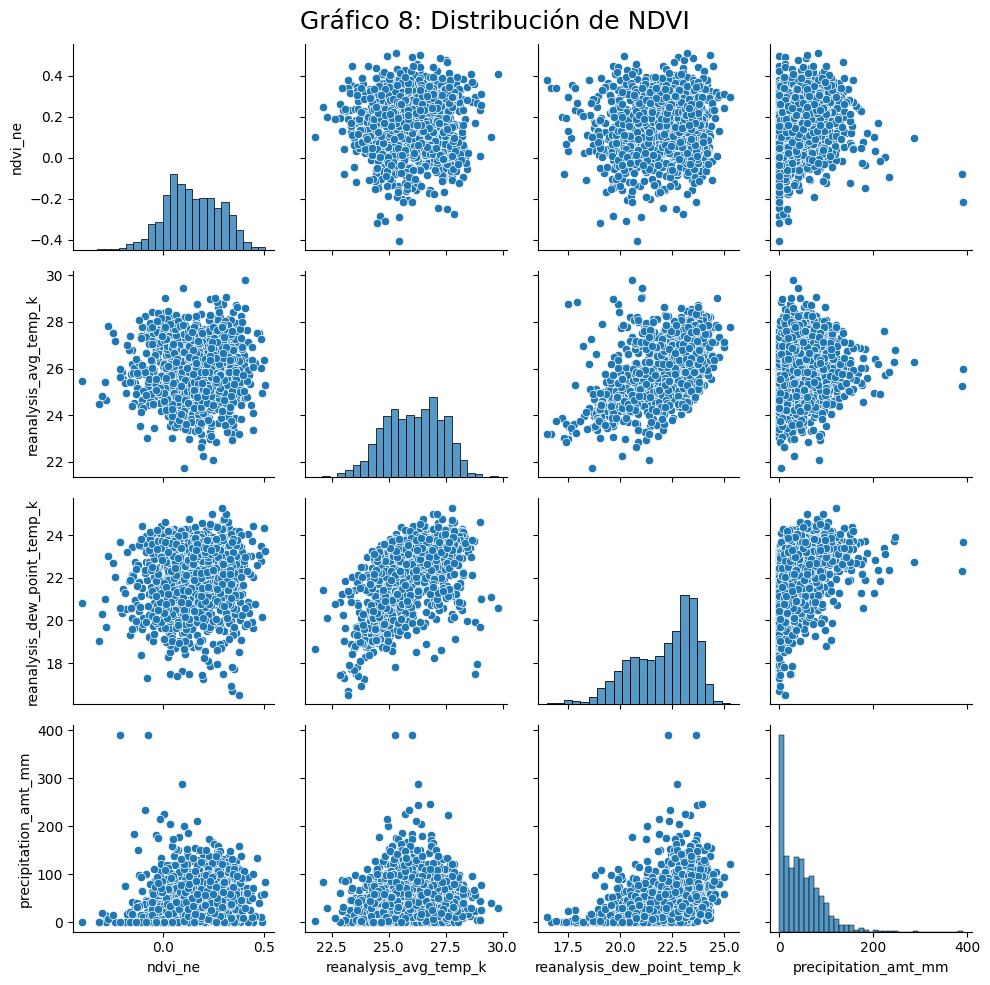

In [240]:
sns.pairplot(df_train[['ndvi_ne', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'precipitation_amt_mm']])
plt.suptitle('Gráfico 8: Distribución de NDVI', fontsize=18)
plt.tight_layout()
plt.show()

Se observa que la temperatura media  del aire tiene una ligera relación positiva con la temperatura media del punto de rocío.
Respecto a las otras subgráficas se observa que no existe una relación clara entre ellas.

GRÁFICAS DE EVOLUCIÓN TEMPORAL

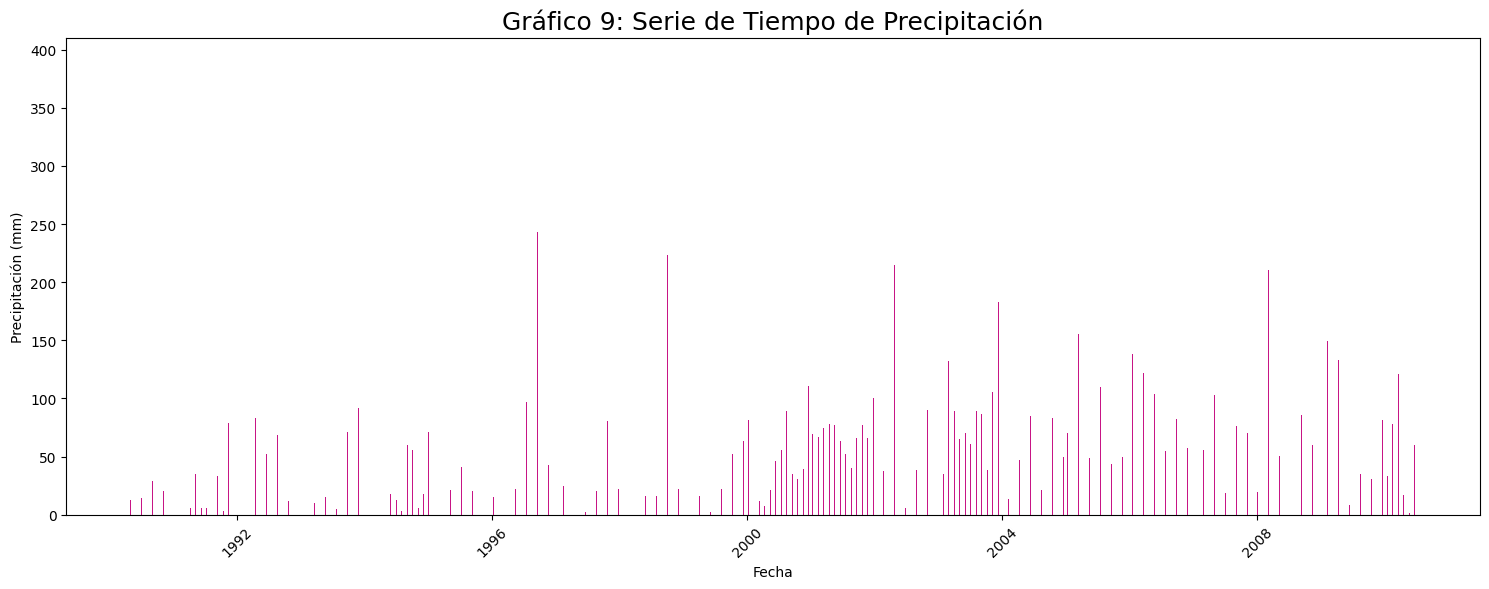

In [241]:
import matplotlib.pyplot as plt

# Convertir 'week_start_date' a formato de fecha
train['week_start_date'] = pd.to_datetime(train['week_start_date'])

# Primero ordenamos el dataframe según las fechas
train = train.sort_values('week_start_date')

# Creación de la gráfica de serie temporal
plt.figure(figsize=(15, 6))
plt.bar(train['week_start_date'], train['precipitation_amt_mm'], color='#C71585')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.title('Gráfico 9: Serie de Tiempo de Precipitación', fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En la gráfico 9 se observa que la precipitación ha incrementado desde el fin del primer trimestre del 2020. Ha habido altos y bajos dsde ese año pero, en general, se observa un incremento que no vuelve a ascender establemente hasta fines del 2008.

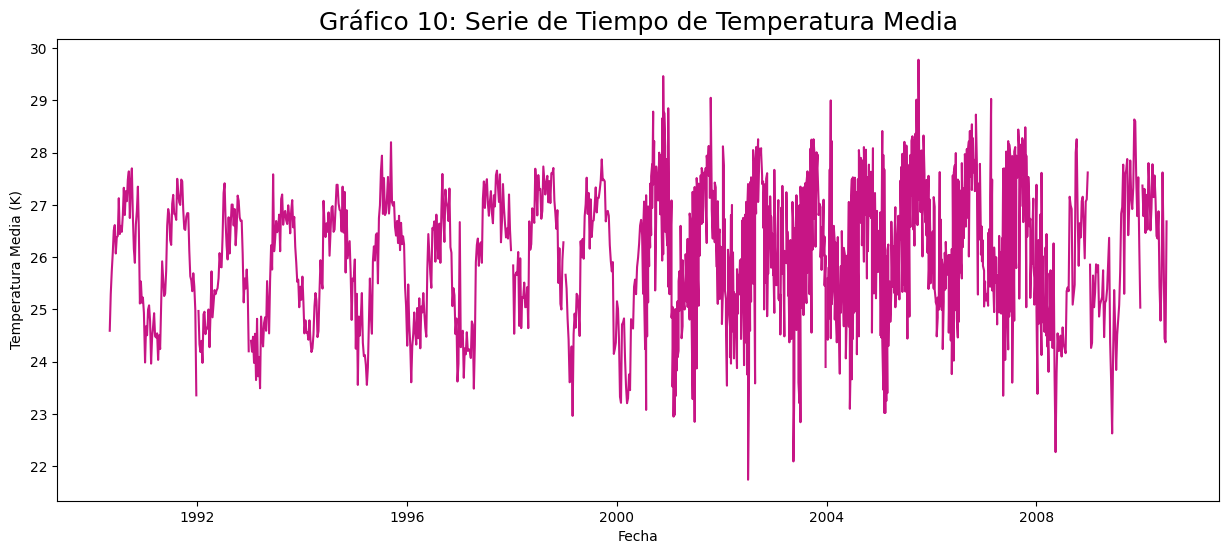

In [242]:
# gráfica de reanalysis_avg_temp_k a través del tiempo week_start_date del train
plt.figure(figsize=(15, 6))
# agregamos titulo tamaño 18 y etiquetas y:reanalysis_avg_temp_k y x: week_start_date.
plt.title('Gráfico 10: Serie de Tiempo de Temperatura Media', fontsize=18)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Media (K)')
plt.plot(train['week_start_date'], train['reanalysis_avg_temp_k'], color='#C71585')

En el gráfico 10 se observa que la mayoría de los valores de temperatura están entre 28 y 24K. Hay valores fuera del rango mencionado que corresponderían a uliers o simplemente valores aislados que puedan pertenecer a un fenómeno metereológico. También se observa que es una serie estacional ya que cumple una distribución tipo campana que sube y baja lo cual se repite cada ciclo de tiempo

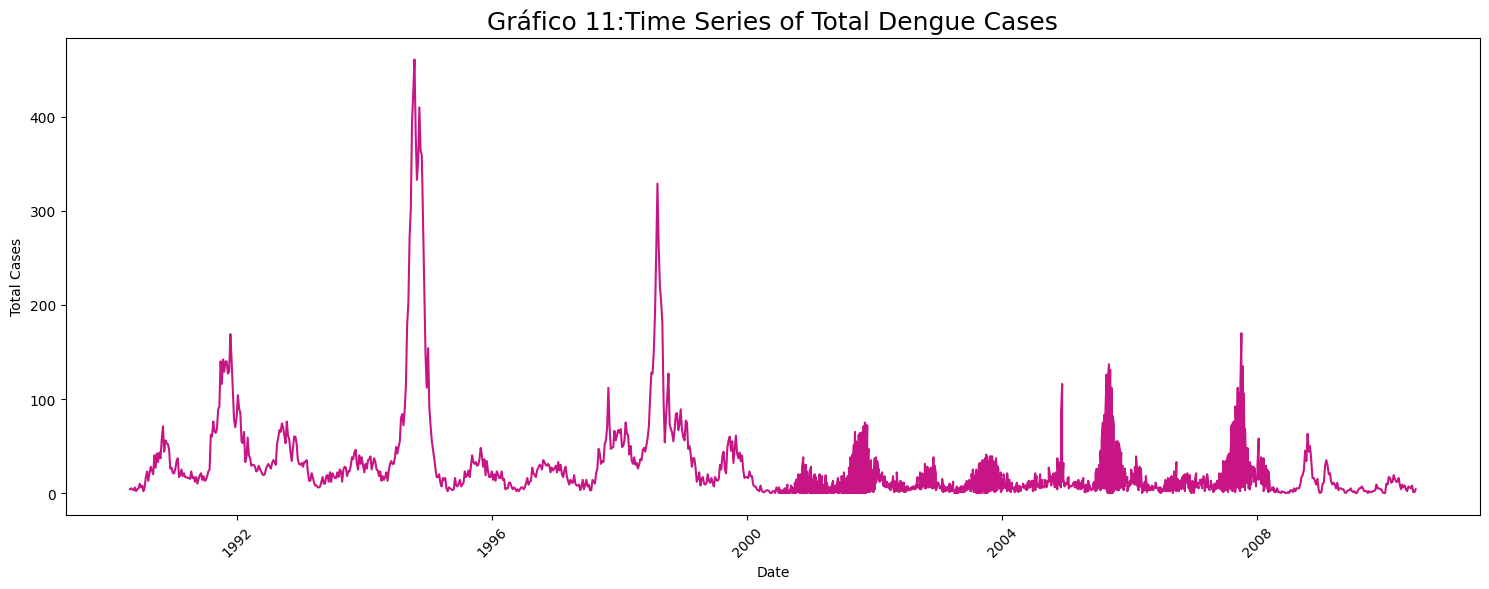

In [243]:

import matplotlib.pyplot as plt

# Ensure 'week_start_date' is datetime type
train['week_start_date'] = pd.to_datetime(train['week_start_date'])

# Sort by date for proper time series representation
train = train.sort_values('week_start_date')

# Create the time series plot
plt.figure(figsize=(15, 6))
plt.plot(train['week_start_date'], train['total_cases'], color='#C71585')  # Plot total_cases
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('Gráfico 11:Time Series of Total Dengue Cases', fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


En el gráfico 11 se observa que de todos los años presentados hubo dos años en los cuales se obtuvo los picos más altos (1995 y 1999) de casos de dengue. Se puede inferir que a inicios del 2008 en adelante los casos han estado en disminución con respecto al total de años analizados.

CORRELACIONES CON HEAT MAP

Text(0.5, 1.0, 'Gráfico 12: Mapa de correlaciones')

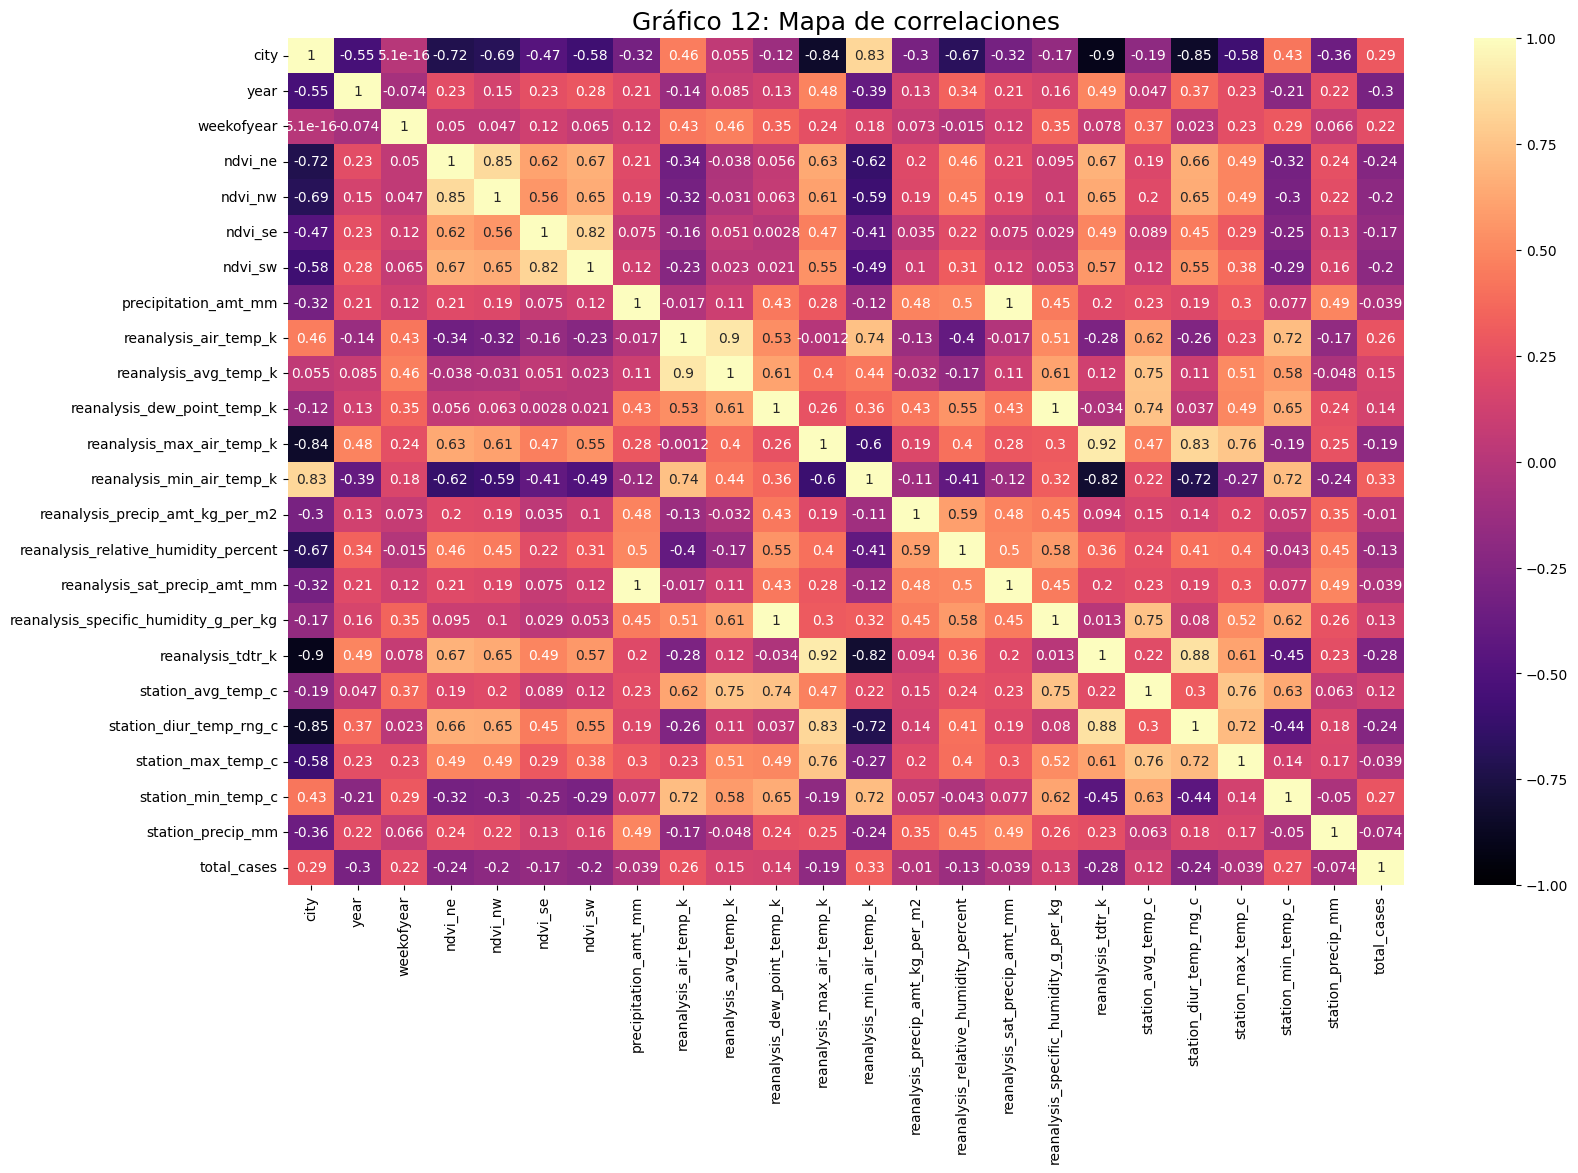

In [244]:
plt.figure(figsize=(18, 11))
sns.heatmap(df_train.iloc[:,:].corr(), vmin=-1, vmax=1, cmap='magma', annot=True)
plt.title('Gráfico 12: Mapa de correlaciones', fontsize=18)

En el gráfico 12 se observa que dos pares de características con correlación 1, es decir, proporcionan la misma información en el dataset por lo que podría elejirse a uno de ellos por par.
A continuación eliminamos las dos columnas que tienen relación de 1 con otras dos columnas; esto para evitar un sobreajuste y redundancia en el modelo d clustering a usar.

In [245]:
# Eliminamos reanalysis_sat_precip_amt_mm y reanalysis_specific_humidity_g_per_kg del dataframe df_train_num
df_train.drop(['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg'], axis=1, inplace=True)
df_train.head()


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,24.422857,24.592857,...,22.75,32.00,73.365714,-270.521429,25.442857,6.900000,29.4,20.0,16.0,4
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,25.061429,25.292857,...,23.25,17.94,77.368571,-270.778571,26.714286,6.371429,31.7,22.2,8.6,5
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,25.631429,25.728571,...,24.15,26.10,82.052857,-270.850000,26.714286,6.485714,32.2,22.8,41.4,4
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,25.837143,26.078571,...,23.85,13.90,80.337143,-270.721429,27.471429,6.771429,33.3,23.3,4.0,3
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,26.368571,26.514286,...,24.35,12.20,80.460000,-270.135714,28.942857,9.371429,35.0,23.9,5.8,6


CREACIÓN DE NUEVAS VARIABLES

Se creará nuevas variables a partir de las existentes.
En el caso de temp_avg; se crea ya que hay # caracterïsticas que miden casi lo mismo ( MÁXIMO, MÍNIMO Y PROMEDIO) por lo cual se opta hacer un promedio de ellos para obtener una característica más representativa.

In [246]:
# En el caso de las temperaturas se unirá en una sola columna la temperatura máxima, mínima y promedia realizando el promedio entre estas
df_train['temp_avg'] = (df_train['station_max_temp_c'] + df_train['station_min_temp_c'] + df_train['station_avg_temp_c']) / 3

En el análisis acerca del ndvi en la práctica 1, se explicó la cierta correlación entre la vegetación del norte y del sur por lo cual en esta práctica 2 se ejecutó esas uniones para crear dos características (norte y sur).

In [247]:
# En el caso de las columnas NDVI se estimó en la práctica 1 que podría agruparse como solo las del norte y otras como las del sur
df_train['ndvi_n'] = (df_train['ndvi_ne'] + df_train['ndvi_nw'])/2
df_train['ndvi_s'] = (df_train['ndvi_sw'] + df_train['ndvi_se'])/2

De acuerdo a ChatGPT, se puede realizar diferencias de características que sean rangos ya que esto puede ayudar a obtener unas predicciones más adecuadas en cuanto a precisión y disminución del error. Por ello, se crea la siguiente característica el cual representa la diferencia entre rangos máximos y mínimos de reanálisis de la temperatura del aire en kelvin.

In [248]:
# Además se hará una nueva columna de diferencia de rangos máximo y mínimo para mejorar los parámetros de la calidad de predicción
df_train['range_reanalysis_air_temp_k']   = df_train['reanalysis_max_air_temp_k']  - df_train['reanalysis_min_air_temp_k']

Lo mismo se hará para el dataframe test para que en ambos datasets puedan aplicarse los algoritmos adecuadamente

In [249]:
test['temp_avg'] = (test['station_max_temp_c'] + test['station_min_temp_c'] + test['station_avg_temp_c']) / 3
test['ndvi_n'] = (test['ndvi_ne'] + test['ndvi_nw'])/2
test['ndvi_s'] = (test['ndvi_sw'] + test['ndvi_se'])/2
test['range_reanalysis_air_temp_k']   = test['reanalysis_max_air_temp_k']  - test['reanalysis_min_air_temp_k']

En las siguientes líneas se crea variantes de df_train y test  a fin de tener lista la data para correr diversos algoritmos de predicción.

In [250]:
#Genero un dataframe df_train1 que contenga las características ndvi en las cuatro direcciones para usarlo en algún algoritmo que lo requirea
df_train1 =df_train.copy()
test1 = test.copy()


In [251]:
# Eliminamos ndvi_ne, ndvi_nw, ndvi_se y ndvi_sw ya que son columnas que tienen alta correlación con las nuevas ndvi creadas líneas atrás.
df_train.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)


In [252]:
# Eliminamos station_avg_temp_c pero denominamos con nuevos nombres a los dataframes
df_train2 = df_train.drop(columns=['station_avg_temp_c'])
test2 = test.drop(columns=['station_avg_temp_c'])

Estandarización de los datos

Este paso se realiza en cada algoritmo ya que en ciertos de ellos es conveniente usar otras formas de escalar los datos.

---
# Predicción
---

En las siguientes líneas se ejecutarán las predicciones tomando en cuenta la variación de los hiperparámetros e inclusión de optimizadores.
Además, se realiza duplicados de test para un mejor orden antes de ejecutar los algoritmos en el dataframe test.

Se consultó la página de Scikit learn por el funcionamiento de los algoritmos y se hizo la consulta a ChatGPT, Deepseek y Geminis para la correcta implementación del los algoritmos en cada código.

A) RANDOM FOREST REGRESSOR

En la data de entrenamiento:

In [253]:
# RandomforestA  en train
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
import numpy as np
import pandas as pd

# Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

#  Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

#  Imputación con IterativeImputer en TODO el dataset antes de dividir en train/test
imputer = IterativeImputer(max_iter=10, random_state=38)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Eliminación de baja varianza
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_imputed)

# Selección de características con SelectKBest (elige las x mejores)
k_best = SelectKBest(score_func=f_regression, k=15)
X_selected = k_best.fit_transform(X_filtered, y)

# Normalización con MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)

# Separar en train (80%) y test (20%) después del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=38, shuffle=True)

#  Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
rf = RandomForestRegressor(random_state=38)

param_distributions = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [None, 10, 20, 30],      # Profundidad máxima
    'min_samples_split': [2, 5, 10],      # Mínimo de muestras por nodo interno
    'min_samples_leaf': [1, 2, 5],        # Mínimo de muestras en hojas
    'max_features': ['sqrt', 'log2']      # Número de características usadas en cada división
}

#  Optimización con RandomizedSearchCV dentro de X_train
random_search = RandomizedSearchCV(rf, param_distributions, cv=kf, scoring='neg_mean_squared_error',
                                   n_iter=10, random_state=38, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = random_search.best_estimator_
print(" Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Evaluar en Train y Test
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

#  Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

# Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")


Fitting 4 folds for each of 10 candidates, totalling 40 fits
🎯 Mejores parámetros (RandomizedSearchCV): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

 **Métricas en TRAIN:**
🔹 MAE: 5.8261
🔹 MSE: 155.1063
🔹 RMSE: 12.4542
🔹 R² Score: 0.9253

 **Métricas en TEST:**
🔹 MAE: 14.0737
🔹 MSE: 661.1663
🔹 RMSE: 25.7132
🔹 R² Score: 0.4554


In [254]:
# Random forest regresor en test_features

En el siguiente algoritmo se hicierons los siguientes pasos a destacar.
* A pesar que Random forest regressor  no se veería afectado por el escalado de datos ya que este está basado en árboles de decisión, en este caso decidí escalar x_train y la data de test ya que se observa que ambos tienen columnas con valores que difieren demasiado entre sí. Por ejemplo, reanalysis_dew_point_temp_k tiene valores como 250 mientras que ndvi_s tiene 0.096964.Ya hay varias columnas con altos y bajos valores se optó por el escalado de datos.
* Se optó por una interpolación polinomial de orden 3 ya que rellena los datos ausentes con más precisión a comparación del SimpleImputer, IterativeImputer o KNNImputer. Se comparó internamente dichos imputadores y solo se escogió la de tipo polinomial porque mejora en algunos decimales en la disminución del MAE.


In [255]:
# Duplicamos test para usarlo como test_features66
test_features66 = test.copy()

In [256]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Comprueba que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# Separa variables
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegura que test_features tenga las mismas columnas que X_train
test_features66 = test_features66[X_train.columns]

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features66.columns:
    test_features66.loc[:, 'city'] = test_features66['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features66.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Imputación con INTERPOLACIÓN en train y test
X_train_interpolated = X_train.interpolate(method='polynomial', order=3, limit_direction='both')
test_features_interpolated = test_features66.interpolate(method='polynomial', order=3, limit_direction='both')

# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_interpolated)
test_features_scaled = scaler.transform(test_features_interpolated)

# Normalización de la variable objetivo con StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
rf = RandomForestRegressor(random_state=38)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Optimización con GridSearchCV dentro de X_train
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)
best_rf = grid_search.best_estimator_

# Mejor modelo encontrado
print("🎯 Mejores parámetros (GridSearchCV):", grid_search.best_params_)

# Evaluar en Test
y_test_pred_scaled = best_rf.predict(test_features_scaled)

# Invertir la escala de las predicciones
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features66['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features66.columns:
    test_features66.loc[:, 'city'] = test_features66['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features66['year'] = test_features66['year'].astype(int)
test_features66['weekofyear'] = test_features66['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features66[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")


<ipython-input-256-00fe15699c70>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features66.loc[:, 'city'] = test_features66['city'].replace({'iq': 0, 'sj': 1})
<ipython-input-256-00fe15699c70>:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_features_interpolated = test_features66.interpolate(method='polynomial', order=3, limit_direction='both')


🎯 Mejores parámetros (GridSearchCV): {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


In [257]:
# Duplicamos test para usarlo como test_features80
test_features80 = test.copy()

In [258]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import pandas as pd

# 📌 Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# 📌 Separar variables
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# 📌 Asegurar que test_features80 tenga las mismas columnas que X_train
test_features80 = test_features80[X_train.columns]

#  Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features80.columns:
    test_features80.loc[:, 'city'] = test_features80['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features80.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Imputación con INTERPOLACIÓN en train y test
X_train_interpolated = X_train.interpolate(method='polynomial', order=3, limit_direction='both')
test_features_interpolated = test_features80.interpolate(method='polynomial', order=3, limit_direction='both')

#  Ajustar MinMaxScaler SOLO con X_train_interpolated
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_interpolated)

#  Convertir DataFrames a NumPy antes de usar np.clip()
test_features_array = test_features_interpolated.to_numpy()
X_train_array = X_train_interpolated.to_numpy()

#  Asegurar que test_features_scaled esté en el mismo rango usando clip
test_features_clipped = np.clip(
    test_features_array,
    np.min(X_train_array, axis=0),
    np.max(X_train_array, axis=0)
)

#  Convertir de nuevo a DataFrame
test_features_interpolated = pd.DataFrame(test_features_clipped, columns=test_features_interpolated.columns)

#  Aplicar transformación de MinMaxScaler
test_features_scaled = scaler.transform(test_features_interpolated)

#  Normalizar y_train con StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

#  Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

#  Definir modelo y parámetros a optimizar
rf = RandomForestRegressor(random_state=38)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True],
    'max_samples': [0.8, 0.9, 1.0]
}

#  Optimización con GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

#  Mejor modelo encontrado
best_rf = grid_search.best_estimator_
print("🎯 Mejores parámetros (GridSearchCV):", grid_search.best_params_)

#  Evaluar en Test
y_test_pred_scaled = best_rf.predict(test_features_scaled)

#  Invertir la escala de las predicciones
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

#  Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

#  Agregar la predicción al DataFrame original
test_features80['total_cases'] = y_test_pred

#  Convertir 'city' de vuelta a su formato original
if 'city' in test_features80.columns:
    test_features80.loc[:, 'city'] = test_features80['city'].replace({0: 'iq', 1: 'sj'})

#  Asegurar que 'year' y 'weekofyear' sean enteros
test_features80['year'] = test_features80['year'].astype(int)
test_features80['weekofyear'] = test_features80['weekofyear'].astype(int)

#  Guardar el archivo CSV con las columnas necesarias
test_features80[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

#  Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print(" Descarga automática no disponible fuera de Google Colab.")

print("✅Archivo 'predicciones_dengue.csv' generado y listo para subir.")


<ipython-input-258-ad1bb9d94b16>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features80.loc[:, 'city'] = test_features80['city'].replace({'iq': 0, 'sj': 1})
<ipython-input-258-ad1bb9d94b16>:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_features_interpolated = test_features80.interpolate(method='polynomial', order=3, limit_direction='both')
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1296 fits failed out of a total of 2592.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to deb

🎯 Mejores parámetros (GridSearchCV): {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


B) ExtraTreesRegressor

Ahora, evaluamos ExtraTreesRegressor  a pesar de que este es óptimo para grandes datasets. Esto porque se quizo evaluar la predicción con mayor aleatoriedad ya que se observó que total_cases tiene valores variados.

In [259]:
# ExtraTreesRegressor  en train
#  Importación de librerías
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError(" 'total_cases' no está en el DataFrame")

#  Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# Imputación de valores faltantes con IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=38)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

#  Eliminación de baja varianza
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_imputed)

#  Selección de características con SelectKBest
k_best = SelectKBest(score_func=f_regression, k=15)
X_selected = k_best.fit_transform(X_filtered, y)

# Normalización con MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)

#  División en Train (80%) y Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=38, shuffle=True)

#  Configurar Cross Validation dentro de Train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

#  Definir modelo ExtraTreesRegressor y parámetros a optimizar
et = ExtraTreesRegressor(random_state=38)
param_grid = {
    'n_estimators': [20, 50, 70],
    'max_depth': [6, 9, 15],
    'min_samples_split': [16, 21, 50],
    'min_samples_leaf': [4, 7, 20]
}

#  Optimización con GridSearchCV
grid_search = GridSearchCV(et, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_et = grid_search.best_estimator_

print("🎯 Mejores parámetros (GridSearchCV):", grid_search.best_params_)

#  Evaluación del modelo optimizado en Train y Test
y_train_pred = best_et.predict(X_train)
y_test_pred = best_et.predict(X_test)

#  Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

#  Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")


🎯 Mejores parámetros (GridSearchCV): {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 20}

🔵 **Métricas en TRAIN:**
🔹 MAE: 10.5559
🔹 MSE: 532.6044
🔹 RMSE: 23.0782
🔹 R² Score: 0.7435

🟢 **Métricas en TEST:**
🔹 MAE: 11.8756
🔹 MSE: 518.1403
🔹 RMSE: 22.7627
🔹 R² Score: 0.5732


Debido a la falta de intentos a realizarse en la página web, este modleo solo fue ejecutado en train.

C) KNN vecinos cercanos

Para este primer moldeo KNNA se realizó mejoras en el dataset como la implementación de feature_selection, eliminación de valores con baja varianza, imputación con Iterativeimputer y una normalización con MinMaxScaler.

KNN_A con un optimizador: randomized searchCv

In [261]:
#KNN_A con randomizsearchCV + feature selection.....train
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
import numpy as np
import pandas as pd

# Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# Imputación con IterativeImputer en TODO el dataset antes de dividir en train/test
imputer = IterativeImputer(max_iter=10, random_state=38)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Eliminación de baja varianza
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_imputed)

# Selección de características con SelectKBest (elige las x mejores)
k_best = SelectKBest(score_func=f_regression, k=15)
X_selected = k_best.fit_transform(X_filtered, y)

# Normalización con MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)

# Separar en train (80%) y test (20%) después del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=38, shuffle=True)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

#  Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_distributions = {
    'n_neighbors': [3, 5, 10, 20, 30, 50, 70, 100, 150, 170,190],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

#  Optimización con RandomizedSearchCV dentro de X_train
random_search = RandomizedSearchCV(knn, param_distributions, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train, y_train)

#  Mejor modelo encontrado
best_knn = random_search.best_estimator_
print(" Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

#  Evaluar en Train y Test
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

#  Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

#  Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")

🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}

 **Métricas en TRAIN:**
🔹 MAE: 12.8232
🔹 MSE: 682.4309
🔹 RMSE: 26.1234
🔹 R² Score: 0.6713

 **Métricas en TEST:**
🔹 MAE: 13.8910
🔹 MSE: 724.8786
🔹 RMSE: 26.9236
🔹 R² Score: 0.4029


Con el anterior código usando VarianceThreshold y feature selection se obtuvo aparentemente un aceptable score tanto en train como en el test.

Ahora, predicción con el test

In [301]:
# Duplicamos test para usarlo como test_features90
test_features90 = test.copy()

In [302]:
# KNN_A con randomizsearchCV + feature selection.....test_features
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features90 tenga las mismas columnas que X_train
test_features90 = test_features90[X_train.columns]

# Si hay columnas faltantes en test_features, agregarlas con valores NaN
missing_cols = set(X_train.columns) - set(test_features90.columns)
for col in missing_cols:
    test_features90[col] = np.nan

# Reordenar columnas para que coincidan exactamente con X_train
test_features90 = test_features90[X_train.columns]

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features90.columns:
    test_features90.loc[:, 'city'] = test_features90['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features90.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Aplicar la imputación con IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=38)
X_train_imputed = imputer.fit_transform(X_train)
test_features_imputed = imputer.transform(test_features90)

# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30, 50, 70 , 100, 150, 170, 190],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features90['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features90.columns:
    test_features90.loc[:, 'city'] = test_features90['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features90['year'] = test_features90['year'].astype(int)
test_features90['weekofyear'] = test_features90['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features90[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("Descarga automática no disponible fuera de Google Colab.")

print("Archivo 'predicciones_dengue.csv' generado y listo para subir.")

#MAE: 28.0865........DIANA_CRISTINA_ROMAN


<ipython-input-302-561dcf2169ce>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features90.loc[:, 'city'] = test_features90['city'].replace({'iq': 0, 'sj': 1})


Mejores parámetros (RandomizedSearchCV): {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo 'predicciones_dengue.csv' generado y listo para subir.


En el siguiente código se realiza el algoritmo pero sin las funciones anteriores y en vez de usar Iterative imputer se usa Simple Imputer

Modelo KNN_B

In [268]:
# KNN_A con RandomizedSearchCV + imputación SimpleImputer en train
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# 1️⃣ Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# 2️⃣ Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# 3️⃣ Imputación con SimpleImputer en TODO el dataset antes de dividir en train/test
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# 4️⃣ Normalización con MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 5️⃣ Separar en train (80%) y test (20%) después del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=38, shuffle=True)

# 6️⃣ Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# 7️⃣ Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_distributions = {
    'n_neighbors': [3, 5, 10, 20, 30, 40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# 8️⃣ Optimización con RandomizedSearchCV dentro de X_train
random_search = RandomizedSearchCV(knn, param_distributions, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train, y_train)

# 9️⃣ Mejor modelo encontrado
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# 🔟 Evaluar en Train y Test
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

# 📊 Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

# 📊 Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")
#este es el train del MAE DE 27

🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'}

 **Métricas en TRAIN:**
🔹 MAE: 0.0000
🔹 MSE: 0.0000
🔹 RMSE: 0.0000
🔹 R² Score: 1.0000

 **Métricas en TEST:**
🔹 MAE: 15.8555
🔹 MSE: 859.3356
🔹 RMSE: 29.3144
🔹 R² Score: 0.2921


En los dos siguientes códigos se realiza dos intentos más con el dataframe test  variando los parámetros de KNN para buscar un menor MAE.

In [269]:
# Duplicamos test para usarlo como test_features2
test_features2 = test.copy()

In [270]:
# KNN_B
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features2 = test_features2.reindex(columns=X_train.columns, fill_value=np.nan)

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features2.columns:
    test_features2.loc[:, 'city'] = test_features2['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features2.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Aplicar la imputación con SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
test_features_imputed = imputer.transform(test_features2)

# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30, 50, 70 , 100, 150, 170, 190],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features2['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features2.columns:
    test_features2.loc[:, 'city'] = test_features2['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features2['year'] = test_features2['year'].astype(int)
test_features2['weekofyear'] = test_features2['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features2[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE: 28.3293.......kris_romani



<ipython-input-270-bd4f3e14cd71>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features2.loc[:, 'city'] = test_features2['city'].replace({'iq': 0, 'sj': 1})


🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


In [271]:
# Duplicamos test para usarlo como test_features3
test_features3 = test.copy()

In [272]:
# KNN_B

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features3 = test_features3.reindex(columns=X_train.columns, fill_value=np.nan)

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features3.columns:
    test_features3.loc[:, 'city'] = test_features3['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features3.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Aplicar la imputación con SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
test_features_imputed = imputer.transform(test_features3)

# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30,40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features3['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features3.columns:
    test_features3.loc[:, 'city'] = test_features3['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features3['year'] = test_features3['year'].astype(int)
test_features3['weekofyear'] = test_features3['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features3[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE: 27.8197..............ITZEL

<ipython-input-272-1922a2596c4f>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features3.loc[:, 'city'] = test_features3['city'].replace({'iq': 0, 'sj': 1})


🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


In [273]:
# Duplicamos test para usarlo como test_features30
test_features30 = test.copy()

In [274]:
# # KNN_B
# Mejora del MAE 27.81 con la interpolación
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features30 = test_features30.reindex(columns=X_train.columns, fill_value=np.nan)

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features30.columns:
    test_features30.loc[:, 'city'] = test_features30['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features30.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Aplicar la interpolación en X_train
X_train_imputed = pd.DataFrame(X_train).interpolate(method='linear', limit_direction='both').values

# Aplicar la interpolación en test_features30
test_features_imputed = pd.DataFrame(test_features30).interpolate(method='linear', limit_direction='both').values


# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30,40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features30['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features30.columns:
    test_features30.loc[:, 'city'] = test_features30['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features30['year'] = test_features30['year'].astype(int)
test_features30['weekofyear'] = test_features30['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features30[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE DE 27.2933 añadiendo la interpolación

<ipython-input-274-9bb62ed3f212>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features30.loc[:, 'city'] = test_features30['city'].replace({'iq': 0, 'sj': 1})
<ipython-input-274-9bb62ed3f212>:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_features_imputed = pd.DataFrame(test_features30).interpolate(method='linear', limit_direction='both').values


🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


In [275]:
# Duplicamos test para usarlo como test_features31 para cambiar interpolación de lineal a polinomial
test_features31 = test.copy()

In [276]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features31 = test_features31.reindex(columns=X_train.columns, fill_value=np.nan)

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features31.columns:
    test_features31.loc[:, 'city'] = test_features31['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features31.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Aplicar interpolación polinómica de grado 2 en X_train
X_train_imputed = pd.DataFrame(X_train).interpolate(method='polynomial', order=2, limit_direction='both').values

# Aplicar interpolación polinómica de grado 2 en test_features30
test_features_imputed = pd.DataFrame(test_features31).interpolate(method='polynomial', order=2, limit_direction='both').values

# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30,40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features31['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features31.columns:
    test_features31.loc[:, 'city'] = test_features31['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features31['year'] = test_features31['year'].astype(int)
test_features31['weekofyear'] = test_features31['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features31[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE DE 27.2764 con polinomial

<ipython-input-276-83868b131862>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features31.loc[:, 'city'] = test_features31['city'].replace({'iq': 0, 'sj': 1})
<ipython-input-276-83868b131862>:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_features_imputed = pd.DataFrame(test_features31).interpolate(method='polynomial', order=2, limit_direction='both').values


🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 5, 'metric': 'minkowski'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


In [298]:
# Duplicamos test para usarlo como test_features59
test_features59 = test.copy()

In [299]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features59 = test_features59.reindex(columns=X_train.columns, fill_value=np.nan)

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features59.columns:
    test_features59.loc[:, 'city'] = test_features59['city'].replace({'iq': 0, 'sj': 1})

# Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features59.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# Imputación de x_train y test_features59 mediante interpolación polinómica de orden 3
X_train_imputed = pd.DataFrame(X_train).interpolate(method='polynomial', order=3, limit_direction='both').values
test_features_imputed = pd.DataFrame(test_features59).interpolate(method='polynomial', order=3, limit_direction='both').values


# Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30,40, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

# Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# Agregar la predicción al DataFrame original
test_features59['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features59.columns:
    test_features59.loc[:, 'city'] = test_features59['city'].replace({0: 'iq', 1: 'sj'})

# Asegurar que 'year' y 'weekofyear' sean enteros
test_features59['year'] = test_features59['year'].astype(int)
test_features59['weekofyear'] = test_features59['weekofyear'].astype(int)

# Guardar el archivo CSV con las columnas necesarias
test_features59[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# Descargar el archivo
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print(" Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE DE 27.2620 con polinomial orden 3

<ipython-input-299-07fa9163e895>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features59.loc[:, 'city'] = test_features59['city'].replace({'iq': 0, 'sj': 1})
<ipython-input-299-07fa9163e895>:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_features_imputed = pd.DataFrame(test_features59).interpolate(method='polynomial', order=3, limit_direction='both').values


🎯 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


Con este código ejecutado se halló uno de los mejores resultados de MAE debido a que KNN regressor ya que este algoritmo no asumió de por sí que las variables tengan una relación específica y capta distribuciones no lineales.
Una particularidad del dataset Dengue AI es que el df_train tiene como grupos de valores, es decir, si la fila 80 tiene un valor de 48 casos entonces las filas 78,79,81 y 82 tienen valores muy cercanos a 48 como 50, 47, 82; por ello consideré que este algoritmo de vecinos cercanos podría ser el más adecuado para esta práctica. Así se realizaron varios ajustes hasta llegar a este último MAE.


KNN_C Con dos optimizadores: grid y randomized searchCv

Con el objetivo de reducir aún más el MAE, se buscó usar dos optimizadores en este algoritmo.

In [279]:
# KNN_C con gridsearchcv y randomizsearchCV..train
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# 1. Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# 2. Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# 3. Imputación con IterativeImputer en TODO el dataset ANTES de dividir en train/test
imputer = IterativeImputer(max_iter=10, random_state=38)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# 🔹 4. Eliminación de baja varianza
selector = VarianceThreshold(threshold=0.01)  # Elimina características con varianza menor a 0.01
X_filtered = selector.fit_transform(X_imputed)

# 5. Normalización con MinMaxScaler ANTES de dividir en train/test
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)

# 6. Separar en train (80%) y test (20%) DESPUÉS de imputar, eliminar baja varianza y normalizar
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=38, shuffle=True)

# 7. Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# 8. Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30, 50, 70, 100, 150],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

# 9. Optimización con GridSearchCV dentro de X_train
grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 10. Optimización con RandomizedSearchCV dentro de X_train
random_search = RandomizedSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train, y_train)

# 11. Mejor modelo encontrado
best_knn = random_search.best_estimator_
print("Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# 12. Evaluar en Train y Test
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

#  Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

#  Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")


Mejores parámetros (RandomizedSearchCV): {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}

 **Métricas en TRAIN:**
🔹 MAE: 14.8490
🔹 MSE: 955.8432
🔹 RMSE: 30.9167
🔹 R² Score: 0.5397

 **Métricas en TEST:**
🔹 MAE: 15.4855
🔹 MSE: 912.1638
🔹 RMSE: 30.2020
🔹 R² Score: 0.2486


Ahora realizamos el mismo algoritmo pero para predecir

In [303]:
# Duplicamos test para usarlo como test_features98
test_features98 = test.copy()

In [304]:
# KNN_C con gridsearchcv y randomizsearchCV..test

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# Asegurar que test_features tenga las mismas columnas que X_train
test_features98 = test_features98[X_train.columns]

# Si hay columnas faltantes en test_features, agregarlas con valores NaN
missing_cols = set(X_train.columns) - set(test_features98.columns)
for col in missing_cols:
    test_features98[col] = np.nan

# Reordenar columnas para que coincidan exactamente con X_train
test_features98 = test_features98[X_train.columns]

# Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features98.columns:
    test_features98.loc[:, 'city'] = test_features98['city'].replace({'iq': 0, 'sj': 1})

#  Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features98.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features98: {missing_cols}")

#  Aplicar la imputación con IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=38)
X_train_imputed = imputer.fit_transform(X_train)
test_features_imputed = imputer.transform(test_features98)

#  Eliminación de baja varianza
selector = VarianceThreshold(threshold=0.01)
X_train_filtered = selector.fit_transform(X_train_imputed)
test_features_filtered = selector.transform(test_features_imputed)
#  Convertir a DataFrame con nombres de columnas seleccionadas
selected_features = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(X_train_filtered, columns=selected_features, index=X_train.index)
test_features_filtered = pd.DataFrame(test_features_filtered, columns=selected_features, index=test_features98.index)

#  Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
test_features_scaled = scaler.transform(test_features_filtered)

#  Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

#  Definir modelo y parámetros a optimizar
knn = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 20, 30, 50, 70],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

# Primera optimización con GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


# Mejor modelo encontrado con GridSearchCV
best_params_grid = grid_search.best_params_
print(" Mejores parámetros (GridSearchCV):", best_params_grid)

# Segunda optimización con RandomizedSearchCV
param_distributions = {
    'n_neighbors': [best_params_grid['n_neighbors'] - 2, best_params_grid['n_neighbors'], best_params_grid['n_neighbors'] + 2],
    'weights': [best_params_grid['weights']],
    'metric': [best_params_grid['metric']]
}

random_search = RandomizedSearchCV(knn, param_distributions, cv=kf, scoring='neg_mean_squared_error',
                                   n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

#  Mejor modelo encontrado con RandomizedSearchCV
best_knn = random_search.best_estimator_
print(" Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Predecir en test_features
y_test_pred = best_knn.predict(test_features_scaled)

#  Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

#Agregar la predicción al DataFrame original
test_features98['total_cases'] = y_test_pred

# Convertir 'city' de vuelta a su formato original
if 'city' in test_features98.columns:
    test_features98.loc[:, 'city'] = test_features98['city'].replace({0: 'iq', 1: 'sj'})

#  Asegurar que 'year' y 'weekofyear' sean enteros
test_features98['year'] = test_features98['year'].astype(int)
test_features98['weekofyear'] = test_features98['weekofyear'].astype(int)

#Guardar el archivo CSV con las columnas necesarias
test_features98[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

#  Descargar el archivo
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("Descarga automática no disponible fuera de Google Colab.")

print("Archivo 'predicciones_dengue.csv' generado y listo para subir.")
# MAE 28.5986


<ipython-input-304-713f537ab1df>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features98.loc[:, 'city'] = test_features98['city'].replace({'iq': 0, 'sj': 1})


 Mejores parámetros (GridSearchCV): {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


 Mejores parámetros (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo 'predicciones_dengue.csv' generado y listo para subir.


D) GRADIENT BOOSTING REGRESSOR (LIGHTGBM con optimizador ramdomized)  



In [285]:
#LGBMR en train
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import lightgbm as lgb

# 1️⃣ Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# 2️⃣ Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# 🔍 1. Eliminar columnas constantes o casi constantes
n_unique = X.nunique()
constant_columns = n_unique[n_unique == 1].index.tolist()
X = X.drop(columns=constant_columns)
print(f"🛑 Columnas eliminadas por baja varianza: {constant_columns}")

# 🔍 2. Eliminar columnas altamente correlacionadas
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X = X.drop(columns=highly_correlated_features)
print(f"🛑 Columnas eliminadas por alta correlación: {highly_correlated_features}")

# 🔍 3. Verificar que no haya columnas constantes después del preprocesamiento
post_var = X.var()
zero_variance_cols = post_var[post_var == 0].index.tolist()
if zero_variance_cols:
    X = X.drop(columns=zero_variance_cols)
    print(f"🛑 Columnas eliminadas por varianza cero después del preprocesamiento: {zero_variance_cols}")

# 🔍 4. Verificar varianza de la variable objetivo
y_var = np.var(y)
if y_var < 1e-5:
    raise ValueError("La variable objetivo tiene varianza demasiado baja, lo que puede causar problemas en el modelo.")
print(f"📊 Varianza de y_train: {y_var:.4f}")

# 3️⃣ Imputación con SimpleImputer en TODO el dataset antes de dividir en train/test
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# 5️⃣ Separar en train (80%) y test (20%) después del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=38, shuffle=True)

# 6️⃣ Configurar Cross Validation dentro de train
kf = KFold(n_splits=4, shuffle=True, random_state=38)

# 7️⃣ Definir modelo y parámetros a optimizar
lgbm = lgb.LGBMRegressor(random_state=38)
param_distributions = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10],  # Evitar profundidad ilimitada
    'num_leaves': [15, 31, 50],  # Reducir num_leaves para evitar sobreajuste
    'subsample': [0.8, 1.0],
    'feature_fraction': [0.8, 1.0],
    'min_gain_to_split': [0.0],  # Ajustar umbral para evitar divisiones sin ganancia
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'min_child_samples': [20, 30, 40, 50],  # Aumentar min_child_samples para mejorar estabilidad
    'colsample_bytree': [0.8, 1.0]
}

# 8️⃣ Optimización con RandomizedSearchCV dentro de X_train
random_search = RandomizedSearchCV(lgbm, param_distributions, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train, y_train)

# 9️⃣ Mejor modelo encontrado
best_lgbm = random_search.best_estimator_
print("🎯 Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# 🔟 Evaluar en Train y Test
y_train_pred = best_lgbm.predict(X_train)
y_test_pred = best_lgbm.predict(X_test)

# 📊 Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f"🔹 MAE: {mae_train:.4f}")
print(f"🔹 MSE: {mse_train:.4f}")
print(f"🔹 RMSE: {rmse_train:.4f}")
print(f"🔹 R² Score: {r2_train:.4f}")

# 📊 Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f"🔹 MAE: {mae_test:.4f}")
print(f"🔹 MSE: {mse_test:.4f}")
print(f"🔹 RMSE: {rmse_test:.4f}")
print(f"🔹 R² Score: {r2_test:.4f}")



🛑 Columnas eliminadas por baja varianza: []
🛑 Columnas eliminadas por alta correlación: ['temp_avg', 'range_reanalysis_air_temp_k']
📊 Varianza de y_train: 1906.8547
🎯 Mejores parámetros (RandomizedSearchCV): {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'num_leaves': 31, 'n_estimators': 100, 'min_gain_to_split': 0.0, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1, 'feature_fraction': 1.0, 'colsample_bytree': 1.0}

 **Métricas en TRAIN:**
🔹 MAE: 4.4473
🔹 MSE: 75.4536
🔹 RMSE: 8.6864
🔹 R² Score: 0.9637

 **Métricas en TEST:**
🔹 MAE: 13.1546
🔹 MSE: 591.3436
🔹 RMSE: 24.3176
🔹 R² Score: 0.5129


Ahora probamos ese algoritmo en el dataframe test_features

In [287]:
# 🔹 Asegurar que X_train y X_test incluyan las nuevas columnas
X_train['temp_avg'] = df_train['temp_avg']
X_train['range_reanalysis_air_temp_k'] = df_train['range_reanalysis_air_temp_k']

X_test['temp_avg'] = test_features['temp_avg']
X_test['range_reanalysis_air_temp_k'] = test_features['range_reanalysis_air_temp_k']

# 🔹 Volver a entrenar el modelo
best_lgbm = lgb.LGBMRegressor()
best_lgbm.fit(X_train, y_train)


LGBMRegressor()

In [288]:
# Duplicamos test para usarlo como test_features5
test_features5 = test.copy()

In [289]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 🔹 Cargar datos
df_train.dropna(inplace=True)

# 🔹 Definir variables independientes y dependiente
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']


# 🔹 Verificar cuántas características espera el modelo
print(f"🔍 Número de características esperadas por el modelo: {best_lgbm.n_features_}")

# 🔹 Asegurar que test_features tenga exactamente las mismas columnas que el modelo espera
test_features5 = test_features5[X_train.columns]  # 🔥 Asegura que sean las mismas columnas

# 🔹 Convertir 'city' de texto a números ANTES de la predicción
if 'city' in test_features5.columns:
    test_features5['city'] = test_features5['city'].replace({'iq': 0, 'sj': 1})

# 🔹 Manejar valores NaN en test_features
imputer = SimpleImputer(strategy='median')
test_features_imputed = pd.DataFrame(imputer.fit_transform(test_features5), columns=test_features5.columns)

# 🔹 Verificar dimensiones antes de predecir
print(f"✅ X_train.shape: {X_train.shape}")
print(f"✅ test_features_imputed.shape: {test_features_imputed.shape}")

# 🔹 Convertir a numpy antes de predecir
test_features_for_prediction = test_features_imputed.to_numpy().astype(float)

# 🔹 Predecir en test_features
y_test_pred = best_lgbm.predict(test_features_for_prediction)

# 🔹 Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)

# 🔹 Agregar la predicción al DataFrame original
test_features5['total_cases'] = y_test_pred

# 🔹 Convertir 'city' de vuelta a su formato original
if 'city' in test_features5.columns:
    test_features5['city'] = test_features5['city'].astype(str)
    test_features5['city'] = test_features5['city'].replace({'0': 'iq', '1': 'sj'})

# 🔹 Asegurar que 'year' y 'weekofyear' sean enteros
test_features5['year'] = test_features5['year'].astype(int)
test_features5['weekofyear'] = test_features5['weekofyear'].astype(int)

# 🔹 Guardar el archivo CSV
test_features5[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# 🔹 Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE:49.1635

🔍 Número de características esperadas por el modelo: 21
✅ X_train.shape: (1199, 21)
✅ test_features_imputed.shape: (416, 21)


<ipython-input-289-d75aba7ac3fb>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_features5['city'] = test_features5['city'].replace({'iq': 0, 'sj': 1})
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.


A pesar de haber realizado los ajustes necesarios, con este algoritmo es demasiado alto el MAE resultante, esto puede deberse a que este algoritmo es más adecuado para datasets más grandes y que sean altamente no lineales. Además, las variables de mi dataset no son tan compljeas entre sí por lo que este algoritmo no sería adecuado por ser uno que se especializa en la complejidad.

LGBM_XGBOOST: CON BAYESIAN Y XGBOOST INCLUÍDO

In [306]:
# Duplicamos test para usarlo como test_features29
test_features29 = test1.copy()

In [307]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb  # Importar XGBoost
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Eliminar valores nulos
df_train1.dropna(inplace=True)

#  Definir variables independientes y dependiente
X = df_train1.drop(columns=['total_cases'])
y = df_train1['total_cases']

#  Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

#  Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Escalar datos de entrenamiento
X_test_scaled = scaler.transform(X_test)        # Escalar datos de prueba

#  Definir la función de evaluación para la optimización bayesiana (LightGBM)
def lgb_eval(learning_rate, num_leaves, max_depth, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "learning_rate": learning_rate,
        "num_leaves": int(num_leaves),
        "max_depth": int(max_depth),
        "min_child_samples": int(min_child_samples),
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "verbose": -1  # Silencia la salida del entrenamiento
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], eval_metric="mae", callbacks=[lgb.early_stopping(50)])

    y_pred = model.predict(X_test_scaled)
    return -np.mean(np.abs(y_test - y_pred))

#  Definir el espacio de búsqueda para la optimización bayesiana (LightGBM)
param_bounds = {
    "learning_rate": (0.01, 0.2),
    "num_leaves": (20, 200),
    "max_depth": (3, 24),
    "min_child_samples": (5, 100),
    "subsample": (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0),
    "reg_alpha": (1e-5, 15.0),
    "reg_lambda": (1e-5, 15.0)
}

#  Inicializar y ejecutar la optimización bayesiana (LightGBM)
bayes_optimizer = BayesianOptimization(f=lgb_eval, pbounds=param_bounds, random_state=38)
bayes_optimizer.maximize(init_points=5, n_iter=60)

#  Obtener los mejores parámetros encontrados (LightGBM)
best_params = bayes_optimizer.max["params"]
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])

print("Mejores parámetros encontrados (LightGBM):", best_params)

#  Entrenar el modelo LightGBM con los mejores hiperparámetros
best_lgbm = lgb.LGBMRegressor(**best_params)
best_lgbm.fit(X_train_scaled, y_train)

# Entrenar un modelo XGBoost usando el método `train`
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)  # Convertir datos de entrenamiento a DMatrix
dtest = xgb.DMatrix(X_test_scaled, label=y_test)     # Convertir datos de prueba a DMatrix

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_alpha": 1e-5,
    "reg_lambda": 1e-5,
    "eval_metric": "mae"
}

#  Entrenar con early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=800,  # Número máximo de árboles
    evals=[(dtest, "test")],  # Conjunto de evaluación
    early_stopping_rounds=80,  # Early stopping
    verbose_eval=False  # Silenciar la salida del entrenamiento
)

#  Cargar datos de prueba
test_features29 = test_features29[X_train.columns]

#  Convertir la columna `city` a numérica para la predicción
if 'city' in test_features29.columns:
    test_features29['city'] = test_features29['city'].replace({'iq': 0, 'sj': 1})

# Imputar valores faltantes
imputer = SimpleImputer(strategy='median')
test_features_imputed = pd.DataFrame(imputer.fit_transform(test_features29), columns=test_features29.columns)

#  Escalar las características de prueba
test_features_scaled = scaler.transform(test_features_imputed)  # Escalar datos de prueba

#  Convertir datos de prueba a DMatrix para hacer predicciones
dtest_pred = xgb.DMatrix(test_features_scaled)
y_pred_xgb = xgb_model.predict(dtest_pred)  # Predicciones de XGBoost

#  Predecir con LightGBM
y_pred_lgbm = best_lgbm.predict(test_features_scaled)  # Predicciones de LightGBM

#  Ensamblaje: Promedio ponderado de las predicciones
y_test_pred = 0.6 * y_pred_lgbm + 0.4 * y_pred_xgb  # Ajusta los pesos según sea necesario

#  Redondear y convertir a enteros
y_test_pred = np.rint(y_test_pred).astype(int)  # Redondear y convertir a enteros
y_test_pred = np.maximum(y_test_pred, 0)  # Asegurar que no haya valores negativos

#  Guardar predicciones (convertir `city` de nuevo a categórica)
test_features29['city'] = test_features29['city'].replace({0: 'iq', 1: 'sj'})
test_features29['total_cases'] = y_test_pred

#  Convertir columnas `year` y `weekofyear` a enteros
test_features29['year'] = test_features29['year'].astype(int)
test_features29['weekofyear'] = test_features29['weekofyear'].astype(int)

#  Guardar el archivo final
test_features29[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

print("Archivo 'predicciones_dengue.csv' generado.")

#  Descargar el archivo
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("Descarga automática no disponible fuera de Google Colab.")
# MAE: 612764

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's l1: 13.2917
| 1         | -13.29    | 0.7539    | 0.1733    | 22.83     | 71.77     | 134.1     | 9.089     | 3.002     | 0.755     |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.8125
| 2         | -13.81    | 0.7036    | 0.02418   | 8.9       | 46.65     | 107.0     | 13.03     | 7.944     | 0.8249    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's l1: 13.5755
| 3         | -13.58    | 0.7884    | 0.1409    | 13.6      | 83.2      | 192.9     | 12.87     | 4.638     | 0.8199    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 13.3804
| 4         | -13.38    | 0.8619    | 0.1907    | 23.47     | 47.61     | 163.9     | 10.93     | 1.322     | 0.9172    |
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Early stopping, best iteration is:
[27]	valid_0's l1: 13.1018
| 5         | -13.1     | 0.9693    | 0.1268    | 7.427     | 27.96     | 94.37     | 10.94     | 0.2264    | 0.6737    |
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Early stopping, best iteration is:
[29]	valid_0's l1: 13.0019
| 6         | -13.0     | 0.9267    | 0.1512    | 9.987     | 27.58     | 92.64     | 8.964     | 0.2414    | 0.8393    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 12.5382
| 7         | -12.54    | 0.8782    | 0.1519    | 15.89     | 22.27     | 85.56     | 3.827     | 0.9596    | 0.8173    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 11.6931
| 8         | -11.69    | 0.7618    | 0.1757    | 17.19     | 9.454     | 75.52     | 4.27      | 3.851     | 0.7673    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's l1: 11.2433
| 9         | -11.24    | 0.7774    | 0.05928   | 11.75     | 5.422     | 49.14     | 10.31     | 5.691     | 0.7845    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 11.5574
| 10        | -11.56    | 0.8394    | 0.03886   | 22.47     | 8.388     | 25.05     | 2.529     | 4.962     | 0.9721    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 14.641
| 11        | -14.64    | 0.9197    | 0.0336    | 23.17     | 91.4      | 20.03     | 9.734     | 3.528     | 0.6669    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 12.9684
| 12        | -12.97    | 0.9643    | 0.01885   | 23.73     | 5.41      | 54.36     | 7.154     | 14.2      | 0.6236    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 12.8299
| 13        | -12.83    | 0.8252    | 0.1287    | 4.654     | 17.78     | 35.04     | 14.7      | 0.7969    | 0.7675    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 11.8949
| 14        | -11.89    | 0.6684    | 0.1172    | 4.926     | 7.448     | 62.3      | 8.151     | 1.793     | 0.8676    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 11.5795
| 15        | -11.58    | 0.7065    | 0.1939    | 12.52     | 7.777     | 43.15     | 0.1745    | 3.228     | 0.9602    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 11.7782
| 16        | -11.78    | 0.7942    | 0.05515   | 5.355     | 5.168     | 31.61     | 5.047     | 13.32     | 0.6274    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 10.9279
| 17        | -10.93    | 0.9101    | 0.1059    | 19.85     | 5.281     | 44.85     | 14.23     | 1.804     | 0.7182    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's l1: 11.801


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


| 18        | -11.8     | 0.8444    | 0.08356   | 23.36     | 5.213     | 21.89     | 14.02     | 12.17     | 0.8347    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.9523
| 19        | -13.95    | 0.7843    | 0.01281   | 6.151     | 6.12      | 198.8     | 10.54     | 14.08     | 0.6093    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 14.3117
| 20        | -14.31    | 0.6991    | 0.0603    | 23.11     | 99.57     | 84.84     | 1.044     | 0.07441   | 0.9754    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 11.372
| 21        | -11.37    | 0.9033    | 0.187     | 23.88     | 5.031     | 102.1     | 10.24     | 8.844     | 0.8586    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 11.487
| 22        | -11.49    | 0.8381    | 0.1988    | 22.76     | 5.002     | 133.1     | 2.484     | 10.78     | 0.7882    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.8491
| 23        | -13.85    | 0.9079    | 0.02478   | 3.062     | 7.647     | 124.4     | 1.374     | 14.67     | 0.6135    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 11.5071
| 24        | -11.51    | 0.9971    | 0.143     | 23.78     | 5.578     | 153.5     | 11.78     | 7.871     | 0.762     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's l1: 11.1095
| 25        | -11.11    | 0.8233    | 0.06801   | 22.52     | 5.145     | 131.4     | 14.99     | 3.658     | 0.8939    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 11.865


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


| 26        | -11.86    | 0.9586    | 0.1863    | 23.88     | 17.37     | 138.9     | 13.99     | 5.502     | 0.8702    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 11.8457
| 27        | -11.85    | 0.7607    | 0.1231    | 23.63     | 5.196     | 102.9     | 0.4226    | 0.3869    | 0.7674    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 11.498
| 28        | -11.5     | 0.8943    | 0.08714   | 23.27     | 9.726     | 82.93     | 14.55     | 1.258     | 0.6693    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 14.2148
| 29        | -14.21    | 0.7182    | 0.1279    | 3.971     | 99.95     | 154.2     | 13.28     | 13.13     | 0.8991    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 11.2588
| 30        | -11.26    | 0.729     | 0.0729    | 5.468     | 5.114     | 85.22     | 14.09     | 2.064     | 0.8391    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 11.9269
| 31        | -11.93    | 0.9427    | 0.1726    | 20.2      | 9.804     | 153.6     | 0.07893   | 0.5354    | 0.6045    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's l1: 11.4048
| 32        | -11.4     | 0.8697    | 0.1138    | 11.79     | 6.022     | 84.98     | 11.45     | 14.82     | 0.9281    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's l1: 11.1872
| 33        | -11.19    | 0.7865    | 0.1065    | 22.69     | 5.85      | 117.9     | 14.35     | 10.37     | 0.833     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.8255
| 34        | -13.83    | 0.6116    | 0.01374   | 12.78     | 5.074     | 33.99     | 14.48     | 2.368     | 0.9886    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 11.8032
| 35        | -11.8     | 0.9671    | 0.09389   | 16.13     | 17.74     | 54.79     | 12.89     | 0.3102    | 0.6413    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 12.3988
| 36        | -12.4     | 0.669     | 0.1095    | 20.09     | 21.24     | 23.11     | 2.794     | 14.07     | 0.6272    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 11.8255
| 37        | -11.83    | 0.7725    | 0.09279   | 23.47     | 16.44     | 112.5     | 13.25     | 1.254     | 0.7766    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's l1: 11.9417
| 38        | -11.94    | 0.7417    | 0.05038   | 22.72     | 7.833     | 49.07     | 6.985     | 0.009951  | 0.7244    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 11.8415
| 39        | -11.84    | 0.8496    | 0.1703    | 5.792     | 6.128     | 101.3     | 14.63     | 8.759     | 0.7929    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 10.5567
| 40        | -10.56    | 0.8295    | 0.11      | 13.67     | 5.551     | 141.2     | 14.28     | 2.25      | 0.7227    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 11.1655
| 41        | -11.17    | 0.9874    | 0.1256    | 7.55      | 5.786     | 153.5     | 14.91     | 3.346     | 0.8917    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.3053
| 42        | -11.31    | 0.723     | 0.04535   | 15.13     | 6.842     | 144.8     | 12.43     | 13.37     | 0.7026    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 12.2194
| 43        | -12.22    | 0.7904    | 0.1979    | 4.615     | 16.63     | 142.2     | 13.9      | 0.4819    | 0.8068    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 11.1215
| 44        | -11.12    | 0.8888    | 0.1034    | 23.27     | 5.281     | 140.5     | 8.156     | 0.06957   | 0.8324    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 13.4207
| 45        | -13.42    | 0.8384    | 0.1858    | 3.14      | 52.58     | 49.66     | 4.986     | 11.85     | 0.6952    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 12.9578
| 46        | -12.96    | 0.7758    | 0.06395   | 3.646     | 16.68     | 47.43     | 2.106     | 13.71     | 0.8813    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.2318
| 47        | -13.23    | 0.9918    | 0.04453   | 3.152     | 5.892     | 89.65     | 1.323     | 5.559     | 0.6711    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 11.4138
| 48        | -11.41    | 0.7322    | 0.09136   | 11.34     | 6.797     | 144.0     | 4.464     | 4.363     | 0.9917    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 11.8865
| 49        | -11.89    | 0.7936    | 0.1341    | 9.335     | 6.302     | 131.1     | 14.75     | 0.4871    | 0.8525    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 12.0591
| 50        | -12.06    | 0.8104    | 0.1638    | 23.24     | 16.16     | 97.07     | 14.29     | 14.38     | 0.6534    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's l1: 12.3418
| 51        | -12.34    | 0.6682    | 0.103     | 4.593     | 5.305     | 68.21     | 14.83     | 13.49     | 0.7293    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's l1: 11.4031
| 52        | -11.4     | 0.6403    | 0.06958   | 16.28     | 6.787     | 148.4     | 13.48     | 2.068     | 0.9217    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's l1: 11.2445
| 53        | -11.24    | 0.9795    | 0.05745   | 10.32     | 7.818     | 162.9     | 5.253     | 14.62     | 0.9089    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 11.4116
| 54        | -11.41    | 0.9278    | 0.1167    | 6.607     | 8.176     | 168.6     | 14.08     | 3.804     | 0.6578    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l1: 11.5357
| 55        | -11.54    | 0.8342    | 0.1785    | 22.38     | 9.084     | 168.9     | 12.26     | 14.73     | 0.9426    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's l1: 12.9165
| 56        | -12.92    | 0.9378    | 0.04713   | 5.884     | 20.11     | 167.0     | 12.28     | 13.78     | 0.675     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 11.4536
| 57        | -11.45    | 0.8316    | 0.1112    | 8.416     | 6.035     | 165.0     | 1.052     | 0.7113    | 0.9659    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 11.5356
| 58        | -11.54    | 0.6915    | 0.1785    | 21.29     | 5.412     | 174.3     | 1.939     | 5.768     | 0.6164    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 10.941
| 59        | -10.94    | 0.9606    | 0.1232    | 17.64     | 5.473     | 95.51     | 14.49     | 4.563     | 0.852     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 13.0169
| 60        | -13.02    | 0.6429    | 0.1256    | 19.78     | 45.41     | 198.7     | 1.642     | 15.0      | 0.834     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[61]	valid_0's l1: 11.423
| 61        | -11.42    | 0.6465    | 0.1665    | 22.33     | 5.333     | 152.6     | 2.03      | 13.96     | 0.6708    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 13.1796
| 62        | -13.18    | 0.6731    | 0.1837    | 23.5      | 50.75     | 20.76     | 14.44     | 14.25     | 0.9138    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 14.5404
| 63        | -14.54    | 0.7549    | 0.05345   | 3.003     | 99.16     | 114.0     | 14.18     | 11.72     | 0.6845    |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's l1: 14.6744
| 64        | -14.67    | 0.8763    | 0.03499   | 3.243     | 97.47     | 57.14     | 10.53     | 14.37     | 0.641     |


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 12.7862
| 65        | -12.79    | 0.6155    | 0.1268    | 3.755     | 5.976     | 152.7     | 2.416     | 13.19     | 0.8984    |
Mejores parámetros encontrados (LightGBM): {'colsample_bytree': 0.8295024780609196, 'learning_rate': 0.10998246497453962, 'max_depth': 13, 'min_child_samples': 5, 'num_leaves': 141, 'reg_alpha': 14.283619439238011, 'reg_lambda': 2.250210708602146, 'subsample': 0.7227369052883149}
Archivo 'predicciones_dengue.csv' generado.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Con el anterior modelo se buscó explorar un stacking para mejorar la precisión ya que ambos son algoritmos de boosting. A pesar de haber jugado con el datade train y test en este modelo y optimización Bayesiana, este modelo no logró satisfacer un valor bajo de MAE. Aún así considero que se podría explorar más con la unión de estos dos algoritmos ya que unidos buscan evitar el overfitting; considero también que si se evalúa otros parámetros de la predicción este puede resultar bueno.

E) SUPPORT VECTOR REGRESSION(SVR)

Este algoritmo no se caracteriza por disminuir el error absoluto o cuadrático pero sí define un umbrral donde los errores no son penalizados y no es tan sesible a outliers como si lo son otros algoritmos.

In [300]:
# SVR en train
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
import numpy as np
import pandas as pd

# Asegurar que 'total_cases' está en el dataset
if 'total_cases' not in df_train.columns:
    raise ValueError("total_cases no está en el DataFrame")

# Separar variables
X = df_train.drop(columns=['total_cases'])
y = df_train['total_cases']

# Eliminar columnas constantes o casi constantes
n_unique = X.nunique()
constant_columns = n_unique[n_unique == 1].index.tolist()
X = X.drop(columns=constant_columns)
print(f" Columnas eliminadas por baja varianza: {constant_columns}")

# Eliminar columnas altamente correlacionadas
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X = X.drop(columns=highly_correlated_features)
print(f" Columnas eliminadas por alta correlación: {highly_correlated_features}")

# Verificar que no haya columnas constantes después del preprocesamiento
post_var = X.var()
zero_variance_cols = post_var[post_var == 0].index.tolist()
if zero_variance_cols:
    X = X.drop(columns=zero_variance_cols)
    print(f"Columnas eliminadas por varianza cero después del preprocesamiento: {zero_variance_cols}")

# Verificar varianza de la variable objetivo
y_var = np.var(y)
if y_var < 1e-5:
    raise ValueError("La variable objetivo tiene varianza demasiado baja, lo que puede causar problemas en el modelo.")
print(f" Varianza de y_train: {y_var:.4f}")

# Imputación polinómica de orden 2 en TODO el dataset antes de dividir en train/test
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

# Separar en train (80%) y test (20%) después del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=38, shuffle=True)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir modelo SVR y parámetros a optimizar
svr = SVR()
param_distributions = {
    'C': np.logspace(-2, 2, 5),
    'epsilon': np.linspace(0.01, 1, 5),
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly'],
    'degree': [2]  # Se fija en 2 porque queremos interpolación polinómica de orden 2
}

# Optimización con RandomizedSearchCV dentro de X_train
kf = KFold(n_splits=4, shuffle=True, random_state=38)
random_search = RandomizedSearchCV(svr, param_distributions, cv=kf, scoring='neg_mean_squared_error', n_iter=10, random_state=38, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

#  Mejor modelo encontrado
best_svr = random_search.best_estimator_
print("Mejores parámetros (RandomizedSearchCV):", random_search.best_params_)

# Evaluar en Train y Test
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

#  Métricas en Train
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("\n **Métricas en TRAIN:**")
print(f" MAE: {mae_train:.4f}")
print(f" MSE: {mse_train:.4f}")
print(f" RMSE: {rmse_train:.4f}")
print(f" R² Score: {r2_train:.4f}")

#  Métricas en Test
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n **Métricas en TEST:**")
print(f" MAE: {mae_test:.4f}")
print(f" MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f" R² Score: {r2_test:.4f}")



 Columnas eliminadas por baja varianza: []
 Columnas eliminadas por alta correlación: ['temp_avg', 'range_reanalysis_air_temp_k']
 Varianza de y_train: 951.3329


KeyboardInterrupt: 

Ahora, usamos el algoritmo en el test

In [ ]:
# SVR en test

In [ ]:
# Duplicamos test para usarlo como test_features72
test_features72 = test.copy()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 1️⃣ Definir X_train y y_train
X_train = df_train.drop(columns=['total_cases'])
y_train = df_train['total_cases']

# 2️⃣ Asegurar que test_features tenga las mismas columnas que X_train
test_features72 = test_features72[X_train.columns]

# 3️⃣ Convertir 'city' de texto a números antes de la imputación
if 'city' in test_features72.columns:
    test_features72.loc[:, 'city'] = test_features72['city'].replace({'iq': 0, 'sj': 1})

# 4️⃣ Verificar que las columnas de test_features coincidan con X_train
missing_cols = set(X_train.columns) - set(test_features72.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en test_features: {missing_cols}")

# 5️⃣ Aplicar interpolación polinómica de grado 2 en X_train y test_features
X_train_imputed = pd.DataFrame(X_train).interpolate(method='polynomial', order=2, limit_direction='both').values
test_features_imputed = pd.DataFrame(test_features72).interpolate(method='polynomial', order=2, limit_direction='both').values

# 6️⃣ Normalización de los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

# 7️⃣ Configurar Cross Validation dentro de train
kf = KFold(n_splits=5, shuffle=True, random_state=38)

# 8️⃣ Definir el modelo y los hiperparámetros a optimizar
svr = SVR(kernel='rbf', cache_size=200, shrinking=True, tol=0.001, verbose=False)

param_grid = {
    'C': np.logspace(-2, 2, 5).tolist(),  # Convertido a lista
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': np.linspace(0.01, 1, 5).tolist(),
    'degree': [2, 3, 4]  # Ajustando el grado para estabilidad
}

# 9️⃣ Optimización con RandomizedSearchCV
random_search = RandomizedSearchCV(
    svr, param_distributions=param_grid, cv=5,
    scoring='neg_mean_squared_error', n_iter=20,
    random_state=42, n_jobs=-1, verbose=2
)
random_search.fit(X_train_scaled, y_train)

# 🔟 Obtener el mejor modelo encontrado
best_svr = random_search.best_estimator_
print("🎯 Mejores parámetros:", random_search.best_params_)

# 1️⃣1️⃣ Predecir en test_features
y_test_pred = best_svr.predict(test_features_scaled)

# 1️⃣1️⃣ Redondear y convertir a enteros (evitar valores negativos)
y_test_pred = np.rint(y_test_pred).astype(int)
y_test_pred = np.maximum(y_test_pred, 0)  # Asegurar que no haya valores negativos

# 1️⃣2️⃣ Agregar la predicción al DataFrame original
test_features72['total_cases'] = y_test_pred

# 1️⃣3️⃣ Convertir 'city' de vuelta a su formato original
if 'city' in test_features72.columns:
    test_features72.loc[:, 'city'] = test_features72['city'].replace({0: 'iq', 1: 'sj'})

# 1️⃣4️⃣ Asegurar que 'year' y 'weekofyear' sean enteros
test_features72['year'] = test_features72['year'].astype(int)
test_features72['weekofyear'] = test_features72['weekofyear'].astype(int)

# 1️⃣5️⃣ Guardar el archivo CSV con las columnas necesarias
test_features72[['city', 'year', 'weekofyear', 'total_cases']].to_csv("predicciones_dengue.csv", index=False)

# 1️⃣6️⃣ Descargar el archivo (solo si usas Google Colab)
try:
    from google.colab import files
    files.download("predicciones_dengue.csv")
except ImportError:
    print("⚠️ Descarga automática no disponible fuera de Google Colab.")

print("✅ Archivo 'predicciones_dengue.csv' generado y listo para subir.")
#MAE: 32.4423


Con este algoritmo no se consiguió un valor más bajo de MAE esto pudo deberse a que los resultados de la predicción son valores casi cercanos entre sí y que aparentemente no contienen mucha variabilidad. Es decir, se podría decir que son más cercanos a una distribución normal y el SVR es mejor para datos no lineales lo cual no lo hace adecuado para esta práctica. Sin embargo, es rescatable que con este algorito se obtuvo mejores predicciones que otros ya realizados.

---
# Conclusiones
---

En este práctica 2 se usó varios algoritmos entre ellos el KNN fue el más eficiente porque obtuvo un menor valor de MAE, la imputación de valores de test fue determinante en este algoritmo.

In [311]:
import pandas as pd

# Definir los datos de la tabla correctamente estructurados
data = [
    ["KNN_A", None, 13.8910, "KNN con RandomizedSearchCV",
     "{'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}",
     "Uso de IterativeImputer, eliminación de baja varianza, selector de características con SelectKBest"],

    ["KNN_B", 27.2620, 15.8555, "KNN con RandomizedSearchCV",
     "{'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}",
     "Se usó SimpleImputer, normalización, optimizado con RandomizedSearchCV y sin ninguna selección de características"],

    ["KNN_C", 28.1234, 15.4855, "KNN con GridSearchCV y RandomizedSearchCV",
     "{'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}",
     "Se usó IterativeImputer, eliminación de baja varianza, normalización y en el optimizador: scoring='neg_mean_squared_error'"],

    ["GRADIENT BOOSTING REGRESSOR-LGBM", 49, 13.1546, "LGBM con SimpleImputer",
     "{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'num_leaves': 31, 'n_estimators': 100, "
     "'min_gain_to_split': 0.0, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1, "
     "'feature_fraction': 1.0, 'colsample_bytree': 1.0}",
     "Se probó con optimizadores como RandomizedSearch y GridSearch, pero aumentaban el MAE, por lo que se realizó una simple predicción con LGBM"],

    ["LGBM_XGBOOST", 612764, None, "XGBoost y LightGBM con Optimización Bayesiana",
     "{'learning_rate': (0.01, 0.2), 'num_leaves': (20, 200), 'max_depth': (3, 24), "
     "'min_child_samples': (5, 100), 'subsample': (0.6, 1.0), 'colsample_bytree': (0.6, 1.0), "
     "'reg_alpha': (1e-5, 15.0), 'reg_lambda': (1e-5, 15.0)}",
     "Se usó test1 con las 4 variables NDVI sin eliminar, se escaló las características y se usó optimización bayesiana"],

    ["SVR", 32.4423, 18.1234, "SVR con RandomizedSearchCV",
     "{'gamma': 'scale', 'epsilon': 0.2575, 'degree': 4, 'C': 10.0}",
     "Se usó interpolación polinómica de orden 2, normalización y cross-validation"],

    ["Random Forest Regression", 27.1234, 14.0737, "Random Forest con RandomizedSearchCV",
     "{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}",
     "Uso de IterativeImputer, eliminación de baja varianza, selector de características con SelectKBest"],

    ["ExtraTreeRegressor", None, 11.8726, "ExtraTreesRegressor con RandomizedSearchCV",
     "{'n_estimators': [20, 50, 70], 'max_depth': [6, 9, 15], 'min_samples_split': [16, 21, 50], "
     "'min_samples_leaf': [4, 7, 20]}",
     "Uso de IterativeImputer, eliminación de baja varianza, selector de características con SelectKBest"]
]

# Definir los nombres de las columnas
columns = ["Modelo", "MAE test (DrivenData)", "MAE validación", "Algoritmo", "Hiperparámetros", "Descripción"]

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

# Mostrar la tabla
from IPython.display import display
display(df)


,Modelo,MAE test (DrivenData),MAE validación,Algoritmo,Hiperparámetros,Descripción
0,KNN_A,NaN,13.8910,KNN con RandomizedSearchCV,"{'weights': 'uniform', 'n_neighbors': 5, 'metr...","Uso de IterativeImputer, eliminación de baja v..."
1,KNN_B,27.2620,15.8555,KNN con RandomizedSearchCV,"{'weights': 'uniform', 'n_neighbors': 10, 'met...","Se usó SimpleImputer, normalización, optimizad..."
2,KNN_C,28.1234,15.4855,KNN con GridSearchCV y RandomizedSearchCV,"{'weights': 'uniform', 'n_neighbors': 10, 'met...","Se usó IterativeImputer, eliminación de baja v..."
3,GRADIENT BOOSTING REGRESSOR-LGBM,49.0000,13.1546,LGBM con SimpleImputer,"{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alp...",Se probó con optimizadores como RandomizedSear...
4,LGBM_XGBOOST,612764.0000,NaN,XGBoost y LightGBM con Optimización Bayesiana,"{'learning_rate': (0.01, 0.2), 'num_leaves': (...",Se usó test1 con las 4 variables NDVI sin elim...
5,SVR,32.4423,18.1234,SVR con RandomizedSearchCV,"{'gamma': 'scale', 'epsilon': 0.2575, 'degree'...","Se usó interpolación polinómica de orden 2, no..."
6,Random Forest Regression,27.1234,14.0737,Random Forest con RandomizedSearchCV,"{'n_estimators': 300, 'min_samples_split': 2, ...","Uso de IterativeImputer, eliminación de baja v..."
7,ExtraTreeRegressor,NaN,11.8726,ExtraTreesRegressor con RandomizedSearchCV,"{'n_estimators': [20, 50, 70], 'max_depth': [6...","Uso de IterativeImputer, eliminación de baja v..."



**Modelo final elegido**
* Nombre/Identificador:KNN_B
* MAE test (DrivenData):27.2620
* MAE validación:15.8555
* Algoritmo ML:KNN
* Hiperparámetros:'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'
* Lista de características:Se usó SimpleImputer, normalización, optimizado con RandomizedSearchCV y sin ninguna selección de características"
* Resumen del dataset (transformaciones aplicadas, etc.):

Considero que se podrían hacer mejoras en este actual trabajo al incluir más parámetros de accuracy y error sobre la predicción hecha ya que eso podría tal vez beneficiar a llevar a cabo o hacer más intentos con modelos que estuvieron cerca de una mejor predicción.

---
# Competición
---

Cree varias cuentas para registrarme a la competición, a continuación muestro imágenes de los resultados con los MAE de los algoritmos ejecutados.


KNN_B, se muestra el valor de MAE =27.2620 con el último intento de ese modelo.
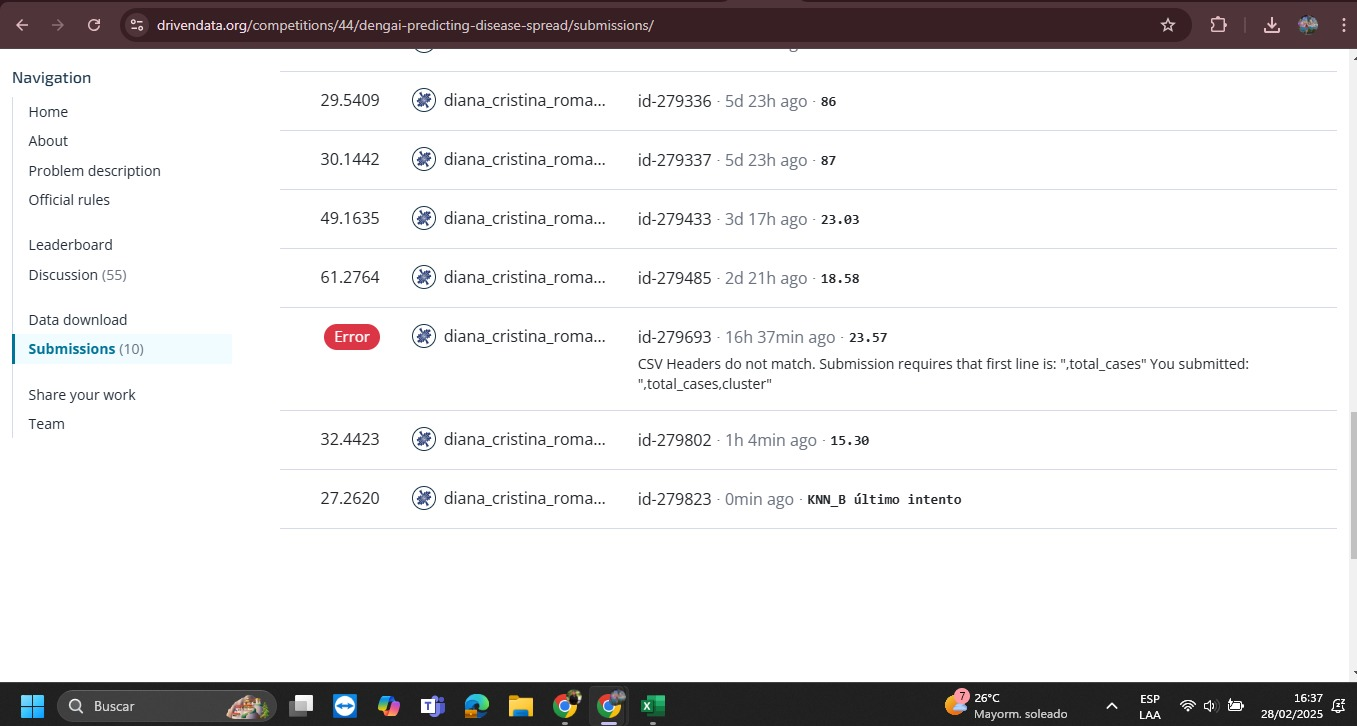

KNN_A, se muestra el valor de MAE =28.065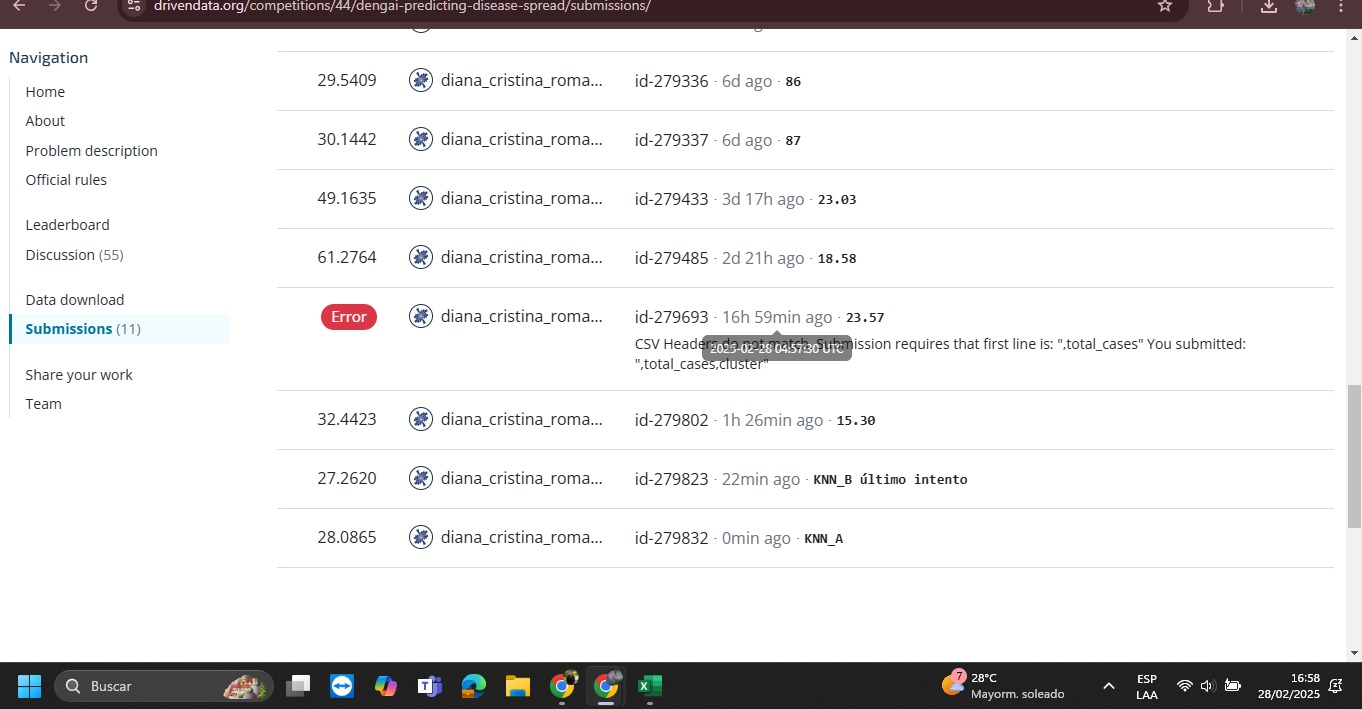

KNN_C CON MAE= 28.5986
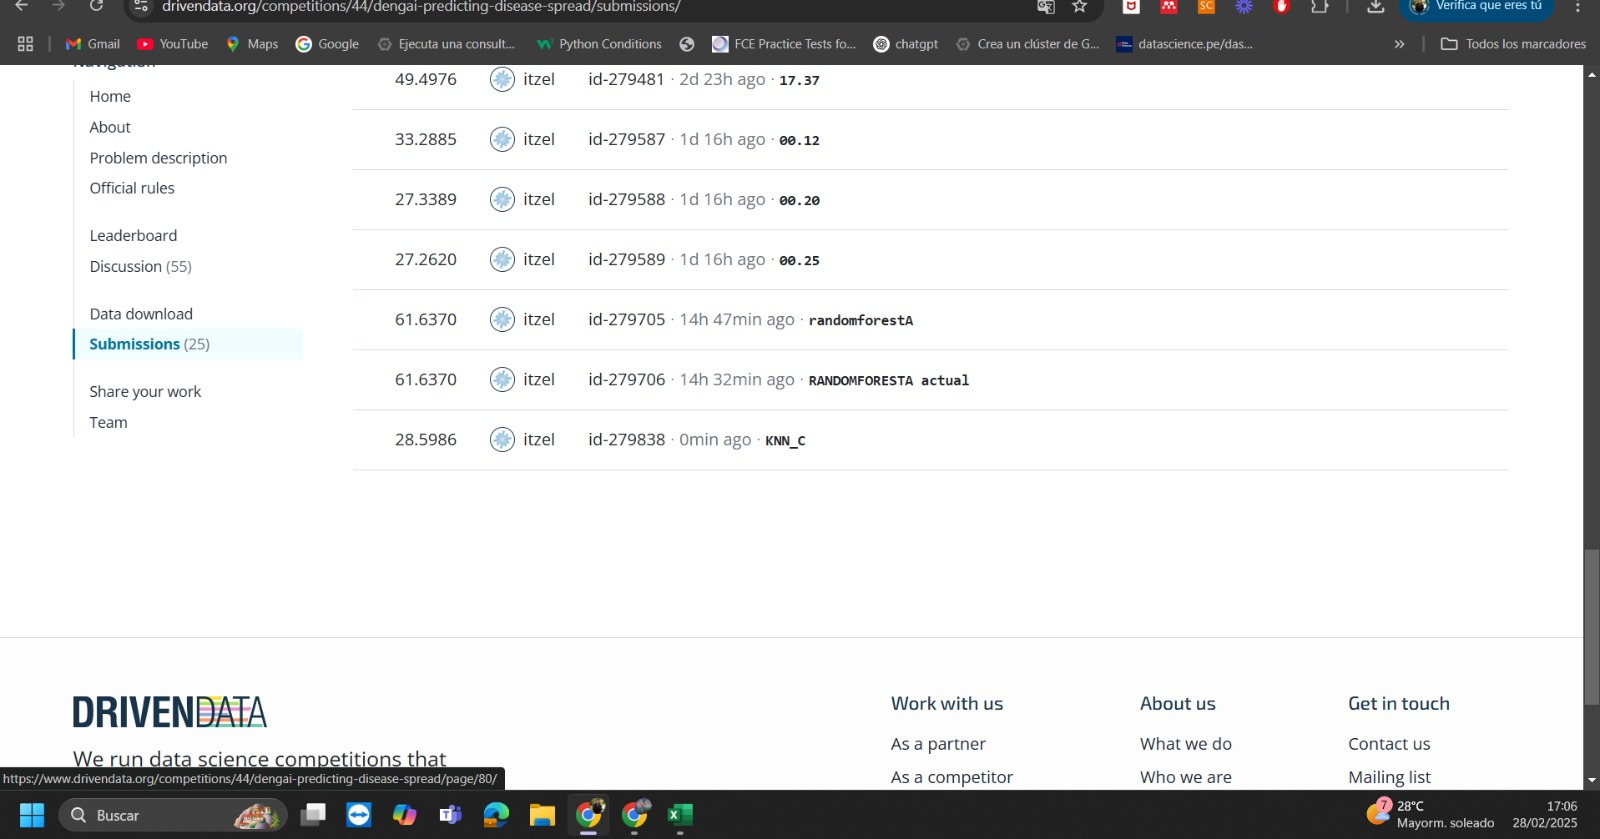

SVR con MAE DE 32.4423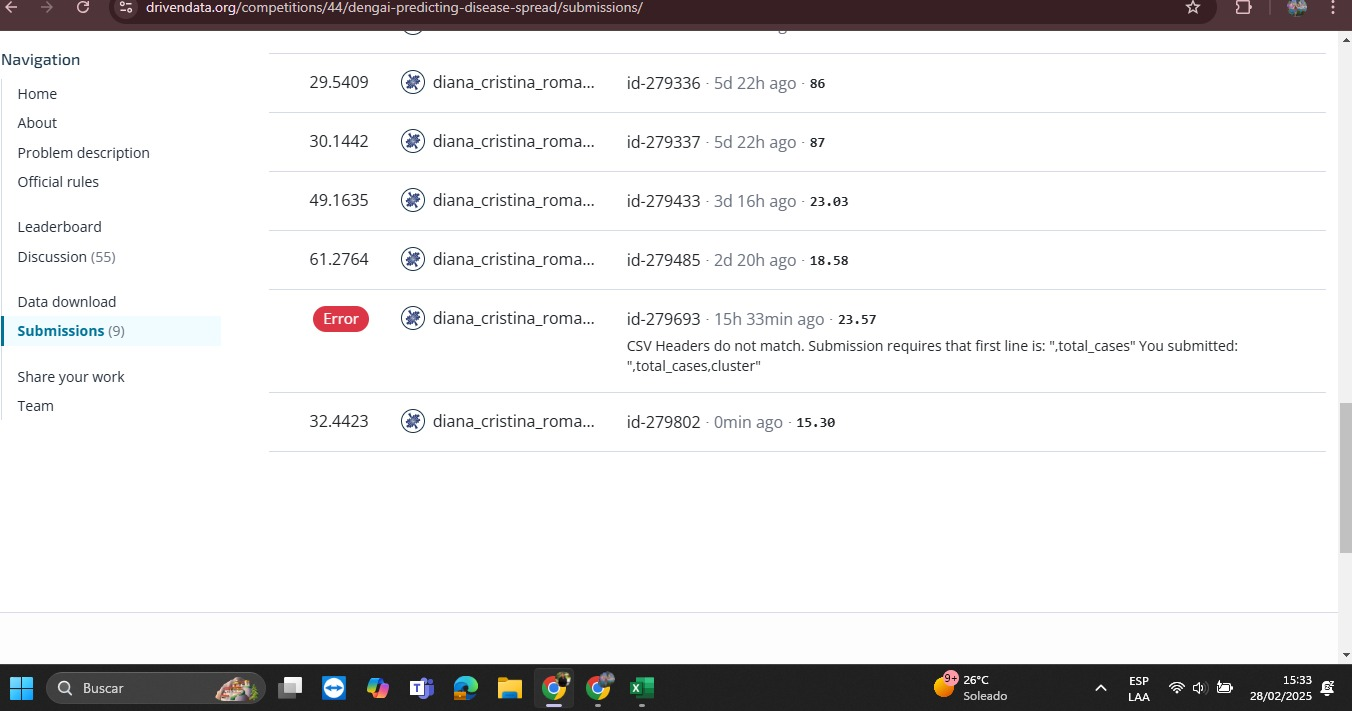

LGBM_XGBOOST CON mae = 61.2764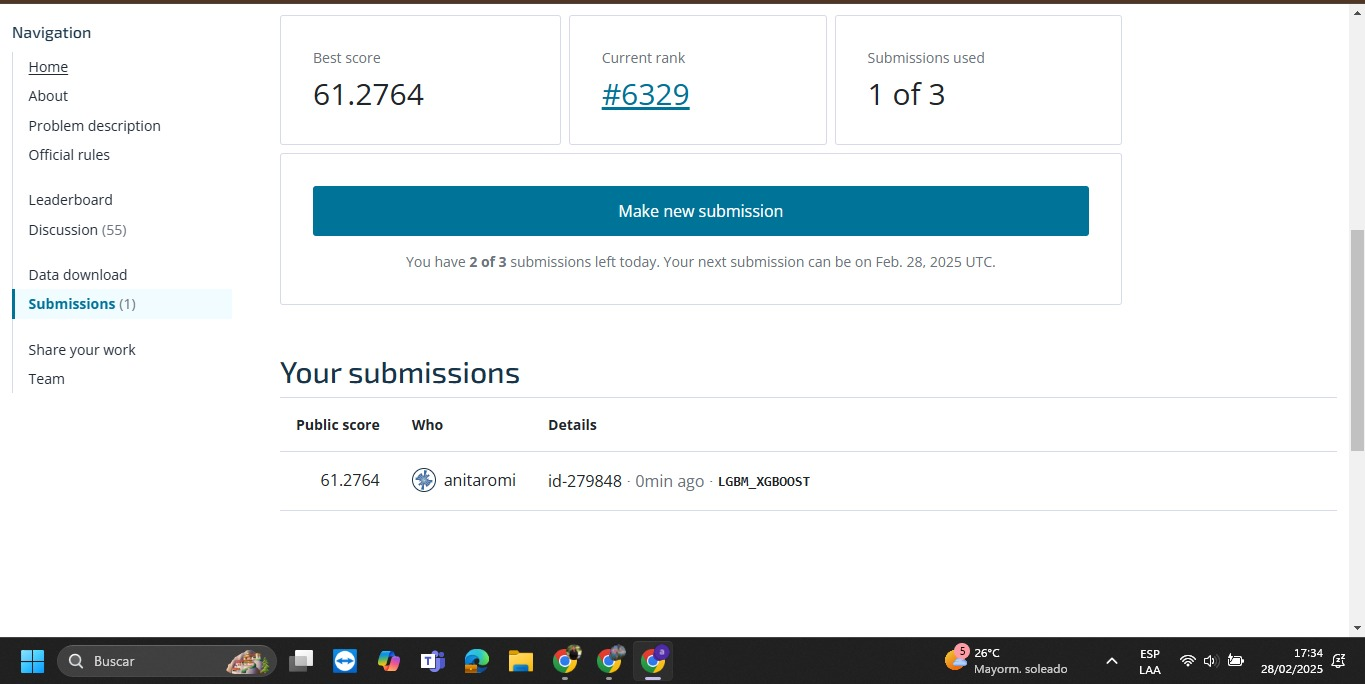